# ImageText

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from nltk.corpus import stopwords
import numpy as np
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import pandas as pd
import seaborn as sns 
from sklearn.cluster import KMeans
import string
import re
import burst_detection as bd
import warnings
import glob
from itertools import dropwhile
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import pickle
import os.path
from collections import defaultdict
import math
from fbprophet import Prophet
import lda
import scipy

from itertools import chain

In [2]:
#settings
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
pd.set_option('display.max_colwidth', -1) #show full columns
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf)

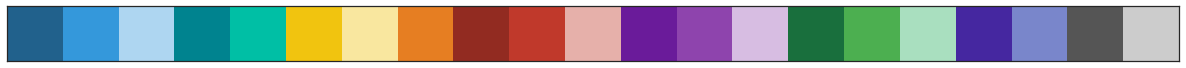

In [3]:
#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

# Functions

In [4]:
#function to extract images stored in a df
def image_extract(x,file_name):
    img_urls = x['image_url']
    dates = x['date']
    for index, (date, url) in enumerate(zip(dates, img_urls)):
        date_x = str(date)[0:10]
        print(date_x)
        try:
            link = urlopen(url)
        except:
            print("Bad URL")
            continue
        try:
            name = "%s_%s_%s.jpg" % (file_name, (index+1), date_x)
            with open(name, "wb") as output:
                output.write(link.read())
        except IOError:
            print("Unable to create %s") % name
            
def doc2ent(string):
    "Shannon entropy for strings (char-level) or tokenized documents (ngram-level)"
    prob = [float(string.count(c))/len(string) for c in dict.fromkeys(list(string))]
    res = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])
    return res

def ent_list(doc_list):
    """ word level entropy for chunked tokenized documents in list """
    res = []
    for d in doc_list:
        tmp = []
        for c in d:
            tmp.append(doc2ent(c))
        res.append(sum(tmp)/float(len(tmp)))
    return res

def renyi_entropy(input, alpha = 2, logbase = 2):
    """
    Renyi entropy for quantifying text diversity/uncertainty/randomness
    - for char and ngram levels
    - alpha = 1 is special case, returns Shannon Entropy
    - not defined for alpha <= 0
    """
    px = [float(input.count(c))/len(input) for c in dict.fromkeys(list(input))]
    if alpha <= 0:
        print('not defined for alpha <= 0')
        return None
    elif alpha == 1:
        return - sum([x*math.log(x,logbase) for x in px])
    else:
        px = [x**alpha for x in px]
        return 1/(1-alpha)* math.log(sum(px),logbase)


def prophet_changepoint_lite(data, n_changepoints=25):
    #data['y'] = np.log(data['y'])
    model = Prophet(n_changepoints=n_changepoints, weekly_seasonality=False)
    model.add_seasonality(name='week_', period=6, fourier_order=3)
    model.fit(data);
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    model.plot_components(forecast)
    figure = model.plot(forecast)
    for changepoint in model.changepoints:
        plt.axvline(changepoint,ls='--', lw=1)
    print(model.changepoints)
    deltas = model.params['delta'].mean(0)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    ax.bar(range(len(deltas)), deltas)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_ylabel('Rate change')
    ax.set_xlabel('Potential changepoint')
    fig.tight_layout()
    
def prophet_changepoint(df, data, n_changepoints=25):
    #data['y'] = np.log(data['y'])
    model = Prophet(n_changepoints=n_changepoints, weekly_seasonality=False)
    model.add_seasonality(name='week_', period=6, fourier_order=3)
    model.fit(data);
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    model.plot_components(forecast)
    figure = model.plot(forecast)
    for changepoint in model.changepoints:
        plt.axvline(changepoint,ls='--', lw=1)
    print(model.changepoints)
    deltas = model.params['delta'].mean(0)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    ax.bar(range(len(deltas)), deltas)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_ylabel('Rate change')
    ax.set_xlabel('Potential changepoint')
    fig.tight_layout()
    
    changepoints_index = model.changepoints.index
    changepoints_dates = model.changepoints.values

    n = 20
    for i, delta in zip(changepoints_index, deltas):
    # if change rate is positive show topic model of that date
    # if change is negative show topic model of previous date
        if delta > 0:
            i = i + 1
            print(df.iloc[i].date)
        else:
            print(df.iloc[i].date)
        top_topics = np.argsort(doc_topic[i,:])[::-1][0:5]
        for ii, topic_dist in enumerate(topic_word):
            if ii in top_topics:
                topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
                print('*Topic {}\n- {}'.format(ii, ' '.join(topic_words)))
        print('---'* 20)
    return model, deltas

def KLD(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

#word count function
def freq_dist(data, n_words):
    ngram_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    return freq_distribution.most_common(n_words)

# read write pickles
def write_pickle(name, input_):
    '''
    name specifies where you want to write which file 
    input defines which variable you want to write as a pickle
    '''
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_out = pickle.dumps(input_)
    with open(name, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])
            

def read_pickle(name):
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    data = bytearray(n_bytes)
    bytes_in = bytearray(0)
    input_size = os.path.getsize(name)
    with open(name, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    return pickle.loads(bytes_in)

#create dataframe with word proportions
def word_proportions(df, word_list):
    all_r = pd.DataFrame(columns=word_list, index=d.index)
    for i, word in enumerate(word_list):
        all_r[word] = pd.concat([df.loc[:, time_frame],
                                df['words'].apply(lambda x: word in x)], axis=1) \
                               .groupby(by=time_frame).sum().reset_index(drop=True)
        if np.mod(i, 100)==0:
            print('total words', len(word_list), 'word', i, 'complete')
    return all_r

def find_bursts(d, all_r, word_list):
    '''
    burst detection function
    '''
    s = 2  #resolution of state jumps; lower s --> fewer but stronger bursts
    gam = 0.5 #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
    n = len(d) #number of timepoints
    smooth_win = 5
    
    all_bursts = pd.DataFrame(columns=['begin', 'end', 'weight'])
    
    for i, word, in enumerate(word_list):
        r = all_r.loc[:, word].astype(int)
        
        #find the optimal state sequence (using the Viterbi algorithm)
        [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win)
        
        #enumerate the bursts
        bursts = bd.enumerate_bursts(q, word)
        
        #find weights of each burst
        bursts_weighted = bd.burst_weights(bursts, r, d, p)
        
        #add the weighted burst to list of all bursts
        all_bursts = all_bursts.append(bursts_weighted, ignore_index=True)
        
        #print a progress report every 100 words
        if np.mod(i,100)==0:
            print('total words', len(word_list), 'word',i,'complete')
    
    return all_bursts.sort_values(by='weight', ascending=False)

def visualize_bursts(n_bursts, bursts, r, title):
    n = len(d) 
    top_bursts = bursts.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]
    #sort bursts by end date
    sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
    #for burst that end at the last timepoint, sort by start
    last_timepoint = np.max(sorted_bursts['end'])
    sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)
    
    heatmap_data = r.loc[:,set(sorted_bursts['label'])]
    
    #find the baseline proportions sum(r)/sum(d) for each label
    baseline_p = heatmap_data.sum(axis=0) / d.sum()

    #convert r values into proportions at each timepoint
    heatmap_data = heatmap_data.apply(lambda x: x/d)

    #sort the rows according to the order used in the timeline
    order = sorted_bursts['label'].drop_duplicates(keep='last').values
    
    #transpose data and reindex the data according to the sorted word order
    heatmap_data = heatmap_data.T.reindex(order)

    #optional: demean proportions
    #heatmap_data = heatmap_data - heatmap_data.mean(axis=1)

    #optional: convert proportions into multiples of the baseline proportion
    heatmap_data = heatmap_data.apply(lambda x: x/baseline_p[x.index])

    #smooth proportions with the same smoothing window used in burst detection
    smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

    #create the heatmap
    plt.figure(figsize=(10,100))
    ax = sns.heatmap(smoothed_heatmap_data[::-1], vmin=0, vmax=2.5, cmap=blue_cmap, yticklabels=True,
                 cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.05, shrink=0.7))
    plt.title('Normalized proportions of "bursting" ' + title + ' words over time')
    plt.xticks(range(0,n,24), range(1945,1995,2), rotation='vertical')

    #create boxes around bursting periods
    for index, burst in sorted_bursts.iterrows():
        
        #define outline positions
        y = smoothed_heatmap_data.index.get_loc(burst['label'])
        y = len(smoothed_heatmap_data) - y - 1 #reverse since it counts from bottom
        xstart = burst['begin'] 
        width = burst['end'] - burst['begin'] + 1
    
        #draw rectangle
        ax.add_patch(plt.Rectangle((xstart,y), width, height=1, alpha=1, 
                           facecolor='none', edgecolor='k', linewidth=1))
    plt.savefig(title + "_heatmap.png", bbox_inches="tight", dpi=300)

## PreProcessing

In [ ]:
path = 'data'
allFiles = glob.glob(path + "/*.tsv")
df = pd.concat((pd.read_csv(f, delimiter='\t') for f in allFiles))

In [ ]:
stop_word = set(stopwords.words('dutch'))
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
excludes = ['objecttype', 'file directory not found']

#df = df[~df['date'].str.contains('date')] #remove duplicate header rows
#df = df[~df['ocr'].astype(str).str.contains('|'.join(excludes))] #remove rows with restricted error msg
#df['date'] = df['date'].astype('datetime64[ns]') #convert dates 
#df = df.sort_values(by='date') #sort by dates
df['ocr_clean'] = df['ocr'].str.replace(regex_pat, '') #only keep words
df['ocr_clean'] = df['ocr_clean'].str.findall('\w{4,}').str.join(' ') #only keep words more than 3 chars
df['ocr_clean'] = df['ocr_clean'].str.lower().str.strip()
df['ocr_clean'] = df['ocr_clean'].str.strip()#lower and remove whitespaces
df['ocr_clean'] = [' '.join(filter(None,filter(lambda word: word not in stop_word, line))) for line in df['ocr_clean'].str.split(' ')]
df['words'] = df['ocr_clean'].apply(lambda x: x.lower().split())
#calculating proportion of characters relative to size of the advertisement. 
df['area'] = df['w'] * df['h']
df['string_length'] = df['ocr_clean'].str.len()
df['character_proportion'] = df['string_length'] / df ['area']
df = df[df['character_proportion'] < 10] #remove ads with lot of text (i.e. ocr errors)

In [ ]:
df = df[~df['date'].str.contains('date')] #remove duplicate header rows
df = df[~df['ocr'].astype(str).str.contains('|'.join(excludes))] #remove rows with restricted error msg
df['date'] = df['date'].astype('datetime64[ns]') #convert dates 
df['publication_year'] = df['date'].apply(lambda x: x.year)
df['publication_month'] = df['date'].apply(lambda x: x.month)
df['publication_day'] = df['date'].apply(lambda x: x.day)

drop_cols = ['min_x', 'min_y', 'max_x', 'max_y', 'w', 'h', 'ocr', 'area']
df.drop(drop_cols, axis=1, inplace=True)

# Read / Write Pickles

In [5]:
df = read_pickle('data/ads.pkl')

In [636]:
car_brands = [
    r'\bopel\b',
    r'\brenault\b',
    r'\baudi\b',
    r'\bsimca\b',
    r'\bpeugeot\b',
    r'\bbuick\b',
    r'\bvolkswagen\b',
    r'\bford\b',
    r'\bStandard\b',
    r'\bTriumph\b',
    r'\bfiat\b',
    r'\bnissan\b',
    r'\bBMW\b',
    r'\bmercedes\b',
    r'\bporsche\b',
    r'\bdaewoo\b',
    r'\btoyota\b',
    r'\balfa romeo\b',
    r'\bsubaru\b',
    r'\bhonda\b',
    r'\blexus\b',
    r'\bmazda\b',
    r'\blada\b',
    r'\bhyundai\b',
    r'\bbentley\b',
    r'\bjaguar\b',
    r'\bcadillac\b',
    r'\bchevrolet\b',
    r'\bchrysler\b',
    r'\bjeep\b',
    r'\balfa romeo\b',
    r'\baudi\b'
    r'\bcitroën\b',
    r'\bDAF\b',
    r'\bdaewoo\b',
    r'\bdaihatsu\b',
    r'\blexus\b',
    r'\blancia\b',
    r'\bland rover\b',
    r'\bmercedes-benz\b',
    r'\bmitsubishi\b',
    r'\bopel\b',
    r'\bporsche\b',
    r'\bsaab\b',
    r'\bseat\b',
]

In [444]:
car_df = df[df['ocr_clean'].str.contains('|'.join(car_brands))]
car_df = car_df[(car_df['w'] > 500) | (car_df['h'] > 500)] #remove ads smaller than 500 w or h
car_df = car_df[car_df['character_proportion'] < 0.00050] #car ads with image and text
car_df['ratio'] = car_df['h'] / car_df['w']
car_df = car_df[car_df['ratio'] < 2]


In [ ]:
car_df['publication_year'] = car_df['date'].apply(lambda x: x.year)
car_df['publication_month'] = car_df['date'].apply(lambda x: x.month)
car_df['publication_day'] = car_df['date'].apply(lambda x: x.day)
car_df['words'] = car_df['ocr_clean'].apply(lambda x: x.lower().split())

In [9]:
#car_df.to_pickle('data/car_14K_ads.pkl')
#car_df = pd.read_pickle('data/car_14K_ads.pkl')

In [7]:
#Extract Sample 
#car_df_sample = car_df.sample(frac=.005)
#image_extract(car_df_sample, 'cars')

In [12]:
len(car_df)

13862

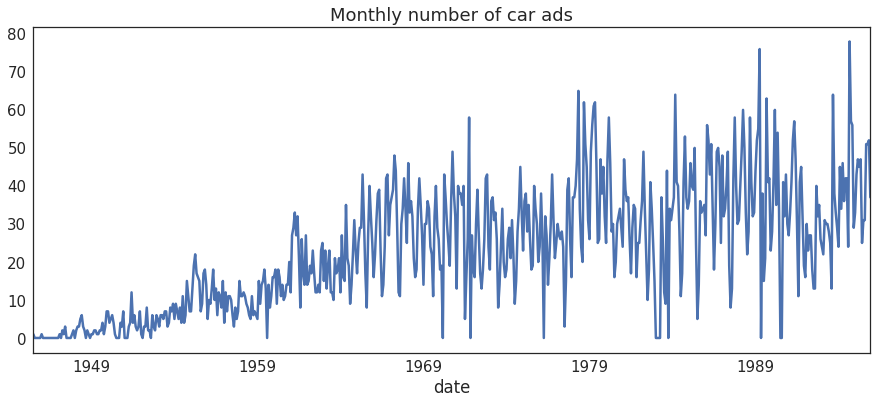

In [11]:
car_df.set_index('date')['ocr_clean'].resample('M').count().plot(title='Monthly number of car ads')
plt.savefig('figures/monthly_ads.png')

# Unique Words

# LDA TOPIC MODELING

In [24]:
#n_features = 10000

K = 100

docs = np.array(car_df['ocr_clean'])

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=None, stop_words=None)
X = tf_vectorizer.fit_transform(docs)
vocab = tf_vectorizer.get_feature_names()

model = lda.LDA(n_topics=K, random_state=1)
model.fit(X)

INFO:lda:n_documents: 13862
INFO:lda:vocab_size: 22756
INFO:lda:n_words: 1254620
INFO:lda:n_topics: 100
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -19125061
INFO:lda:<10> log likelihood: -11828403
INFO:lda:<20> log likelihood: -11069007
INFO:lda:<30> log likelihood: -10824921
INFO:lda:<40> log likelihood: -10707290
INFO:lda:<50> log likelihood: -10634316
INFO:lda:<60> log likelihood: -10585768
INFO:lda:<70> log likelihood: -10550903
INFO:lda:<80> log likelihood: -10526685
INFO:lda:<90> log likelihood: -10505392
INFO:lda:<100> log likelihood: -10486157
INFO:lda:<110> log likelihood: -10471498
INFO:lda:<120> log likelihood: -10460611
INFO:lda:<130> log likelihood: -10452254
INFO:lda:<140> log likelihood: -10445954
INFO:lda:<150> log likelihood: -10434590
INFO:lda:<160> log likelihood: -10428328
INFO:lda:<170> log likelihood: -10419974
INFO:lda:<180> log likelihood: -10417508
INFO:lda:<190> log likelihood: -10413905
INFO:lda:<200> log likelihood: -10410636
INFO:lda:<210> log likel

INFO:lda:<1950> log likelihood: -10324240
INFO:lda:<1960> log likelihood: -10325062
INFO:lda:<1970> log likelihood: -10322227
INFO:lda:<1980> log likelihood: -10325545
INFO:lda:<1990> log likelihood: -10326263
INFO:lda:<1999> log likelihood: -10323389


In [27]:
pickle.dump(vocab, open('models/topic_models/K_100_vocab.sav', 'wb'))
pickle.dump(model, open('models/topic_models/K_100_model.sav', 'wb'))
print("Model Saved!!")

Model Saved!!


In [21]:
with open('models/topic_models/D_K_100_vocab.sav', 'rb') as pickle_file:
    vocab = pickle.load(pickle_file)

with open('models/topic_models/D_K_100_model.sav', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [28]:
topic_word = model.topic_word_
n = 25
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))

*Topic 0
- peugeot kunt junior deurs lening rente accent betalen sterk maanden uitvoeringen extras jaar aanbetaling talbot waarbij heel jubilee vanaf maand voorwaarden zwarte huidige auto succes
*Topic 1
- prijs prijzen waarde kans bestaande gesteld twee gulden beschikbaar philips extra cent loten ford giro briefkaart oplossing trekking kaart iedere loterij kansen rebus december stuur
*Topic 2
- telefoon amsterdam automobielbedrijf dealer chrysler garage automobiel dodge service showroom plymouth valiant firma dealers hilversum official automobielbedrijven breda haag nieuwe benelux lijn advertentie omstreken amerikaanse
*Topic 3
- show gratis nieuwe vanaf zaterdag alle tijdens showroom modellen kunt onze maart april welkom hyundai prijzen jaar oktober vrijdag november harte dagen december september donderdag
*Topic 4
- nieuwe liter alle prestaties interieur zeer leverbaar vanaf komfort techniek alleen standaard zelfs vormgeving uiterst dashboard klasse luxe motoren onafhankelijke geava

*Topic 65
- telefoon banden band elke goed amsterdam jaar advertentie autobanden nieuwe vele gebr firma hoek goede bobanden haarlem jaren betrouwbaar dagelijks verkrijgbaar volledige betrouwbare beekman veilig
*Topic 66
- fiat deurs lang prijs leonard prijzen ritmo goedkoopstraat amsterdam danil special kmpu inkl vaste afleveringskosten mirafiori alle motor uitvoering bumpers industriegebied rijders versnellingen agent automaat
*Topic 67
- saab turbo automobielbedrijf auto alle maatschappij nieuwe automobiel onze import saabs enige eerste bendix veiligheid vianen zware pers proefrit amsterdam modellen zeer alleen goed drievoudige
*Topic 68
- nieuwe ruimte prestaties jaar auto uiterst lage motoren hoge vanaf comfort totaal veiligheid diesel ongekend proefrit vele zeer alle klasse zuinige bewezen zowel duurzaamheid extra
*Topic 69
- benzine chevron wagens auto volle autos wagen type champion bougies motor werden advertentie testen normaal benzineverbruik normale kilometers tank zuiniger 

In [ ]:
# Make list of unique top LDA words
topic_word = model.topic_word_

n = 100
topic_words = []
lda_words = []
for i, topic_dist in enumerate(topic_word):
    topic_words.append(np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1])
    for topic in topic_words:
        for word in topic:
            if word not in lda_words:
                lda_words.append(word)

write_pickle(lda_words, 'lda_words.pkl')

In [30]:
doc_topic = model.doc_topic_
print("type(doc_topic): {}".format(type(doc_topic)))
print("shape: {}".format(doc_topic.shape))

type(doc_topic): <class 'numpy.ndarray'>
shape: (13862, 100)


In [31]:
doc_topic_t = doc_topic.T
dates_ = car_df['date']

In [32]:
dates_ = car_df['date']

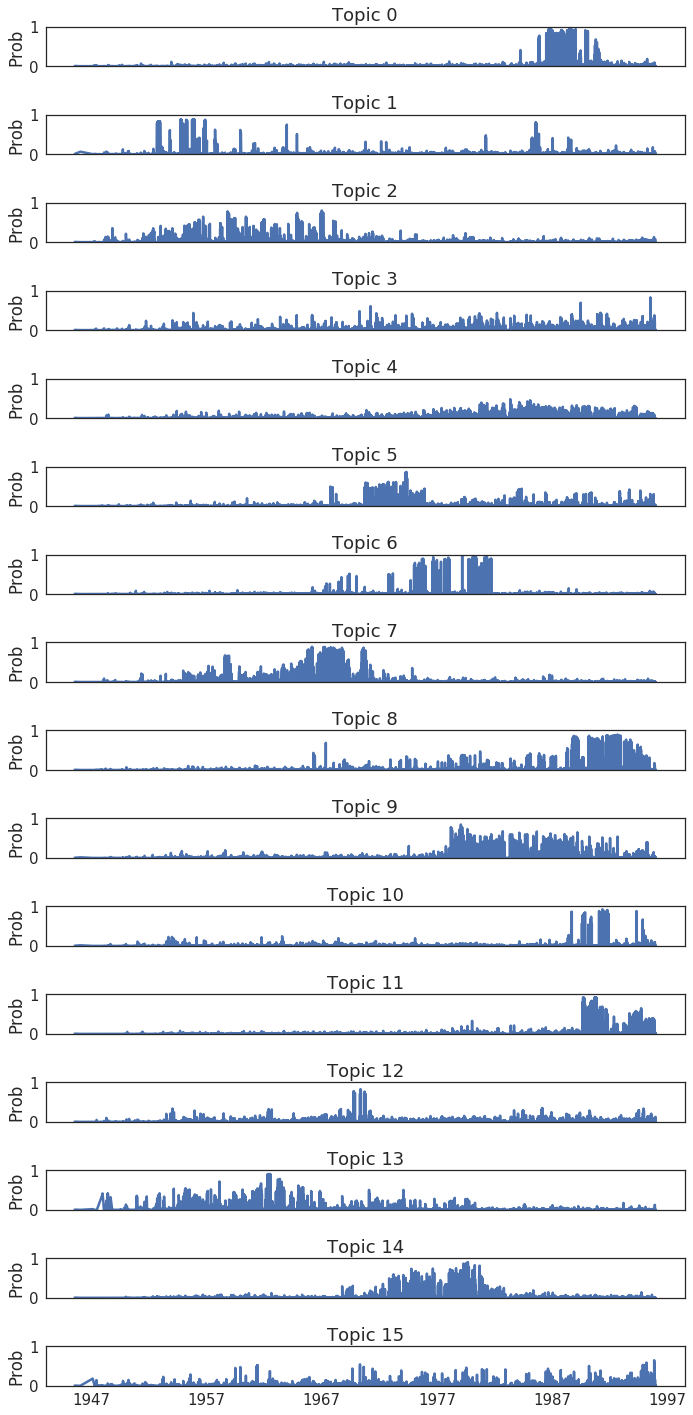

In [33]:
f, ax= plt.subplots(16, 1, figsize=(10, 20), sharex=True)

for k in range(0,16):
    ax[k].plot(dates_, doc_topic_t[k])
    #ax[i].set_xlim(-1, 16)
    ax[k].set_ylim(0, 1)
    ax[k].set_ylabel("Prob")
    ax[k].set_title("Topic {}".format(k))

    
plt.tight_layout()
plt.show()

# Detecting Bursts
### Technique from: https://github.com/nmarinsek/burst_analysis/blob/master/fMRIarticle_bursts.ipynb

In [36]:
time_frame = ['publication_year', 'publication_month']
#count the number of articles published each month
d = car_df.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)



In [ ]:
all_lda_words = word_proportions(car_df, lda_words)

In [ ]:
# burst_lda gamma 0.5, s=2.0
bursts_lda = find_bursts(d, all_lda_words, lda_words)

In [643]:
#all_lda_words.to_pickle('all_lda_words.pkl')
#bursts_lda.to_pickle('bursts_lda.pkl')

In [34]:
# load pickles of words
unique_words = pd.read_pickle('models/bursts/14_K_all_unique_words.pkl')
lda_words = pd.read_pickle('models/bursts/all_lda_words.pkl')

# load bursts
bursts_unique = pd.read_pickle('models/bursts/14_K_burst_unique.pkl')
bursts_lda = pd.read_pickle('models/bursts/bursts_lda.pkl')

# Visualize bursts

In [38]:
## Calculate relative burstiness per year

n = len(d) 
sorted_bursts = bursts_unique.sort_values('end', ascending=False).reset_index(drop=True)
last_timepoint = np.max(sorted_bursts['end'])

sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:].sort_values(by='begin', ascending=False).reset_index(drop=True)
    
heatmap_data = lda_words.loc[:,set(sorted_bursts['label'])]
    
#convert r values into proportions at each timepoint
heatmap_data = heatmap_data.apply(lambda x: x/d)

#smooth proportions with the same smoothing window used in burst detection
smoothed_heatmap_data = heatmap_data.rolling(window=3, center=True, axis=1).mean()

heatmap_data['total'] = heatmap_data.sum(axis=1)

In [39]:
times = car_df.groupby(['publication_year', 'publication_month'])['words'].count().reset_index()
times['dates'] = pd.to_datetime((times.publication_year*100+times.publication_month).apply(str),format='%Y%m')

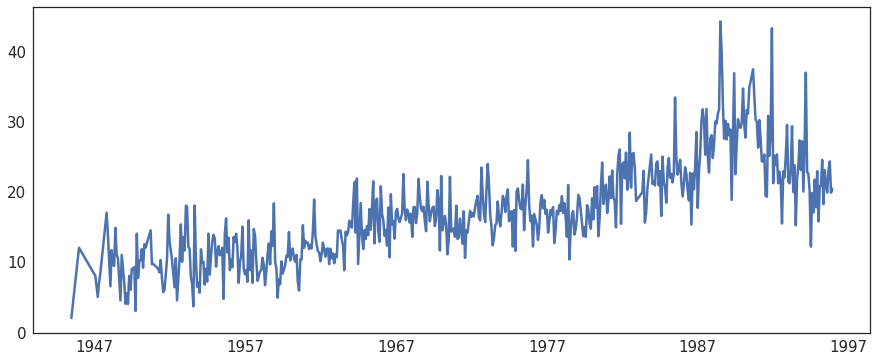

In [40]:
y= heatmap_data['total']
x=times['dates']

plt.plot(x, y)
plt.savefig('figures/yearly_burstiness.png')

In [654]:
drop_cols = ['publication_year', 'publication_month']
times.drop(drop_cols, axis=1, inplace=True)

times.columns = ['y', 'ds']

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45    1951-11-01
90    1955-10-01
134   1959-06-01
179   1963-04-01
224   1967-01-01
269   1970-11-01
314   1974-09-01
358   1978-06-01
403   1982-03-01
448   1986-05-01
Name: ds, dtype: datetime64[ns]
1951-07-07 00:00:00
*Topic 4
- fiat wagen motor nieuwe ford alle prijs grote renault dealer ruimte rijden proefrit telefoon luxe alleen achter wegligging comfort snel
*Topic 12
- auto dauphine dealer wagen fiat comfort rijden chevrolet nederland anglia chrysler automatische klasse verwarming europese official renault proefrit lijn automobielbedrijven
*Topic 30
- telefoon ford prijs prijzen waarde nieuwe kans haag bestaande cent twee gesteld nederland renault advertentie loten philips beschikbaar gulden alle
*Topic 54
- jaar vraagt sollicitaties ford afdeling leeftijd richten opleiding staat enige ervaring gevraagd onze inlichtingen goede opel schriftelijke zeer nieuw koop
*Topic 61
- fiat opel ford rekord taunus renault luxe telefoon auto mercedes radio garantie nieuw peugeot chevrolet k

*Topic 9
- hertz mercedes zegt diesel wagens telef ford postbus autos chevron veiligheid radio mercedesbenz nederland mazda datsun kosten alle geopend audi
*Topic 18
- auto autos fiat mercedes onze ruimte benzine mercedesbenz bekleding dinpk motor jaar groter mazda binnen kleur automobielbedrijf diesel maken chevron
*Topic 21
- autobedrijf automobielbedrijf garage auto gebr eindhoven groningen nijmegen rotterdam utrecht service haarlem garagebedrijf breda maastricht arnhem telefoon kunt hilversum automobiel
*Topic 24
- autom garage nefkens bedrijf bedr bekleding fiat motor peugeot dinpk gebr portieren liter achter autobedr onafhankelijk alle wielen kunstieder geveerd
------------------------------------------------------------


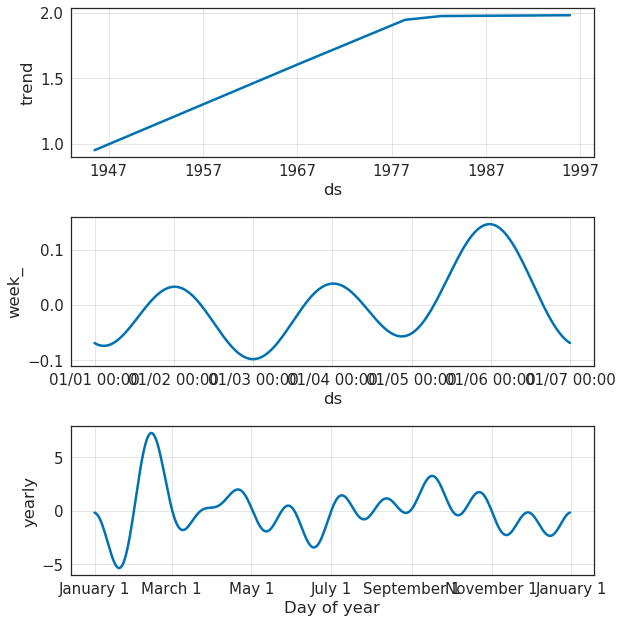

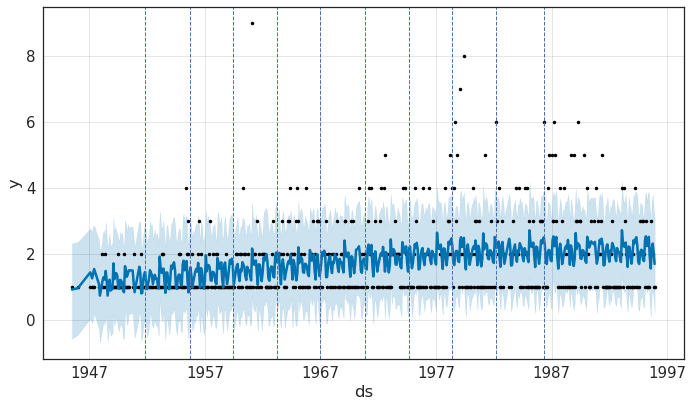

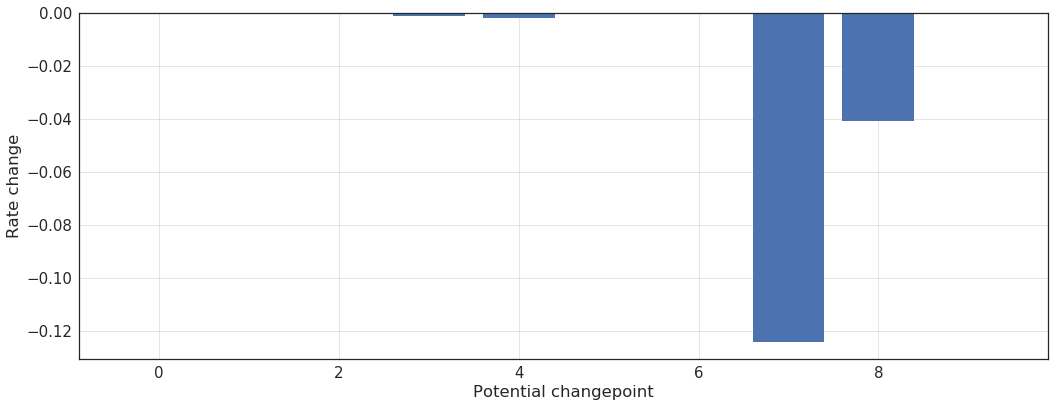

In [655]:
model_, deltas = prophet_changepoint(car_df, times, 10)

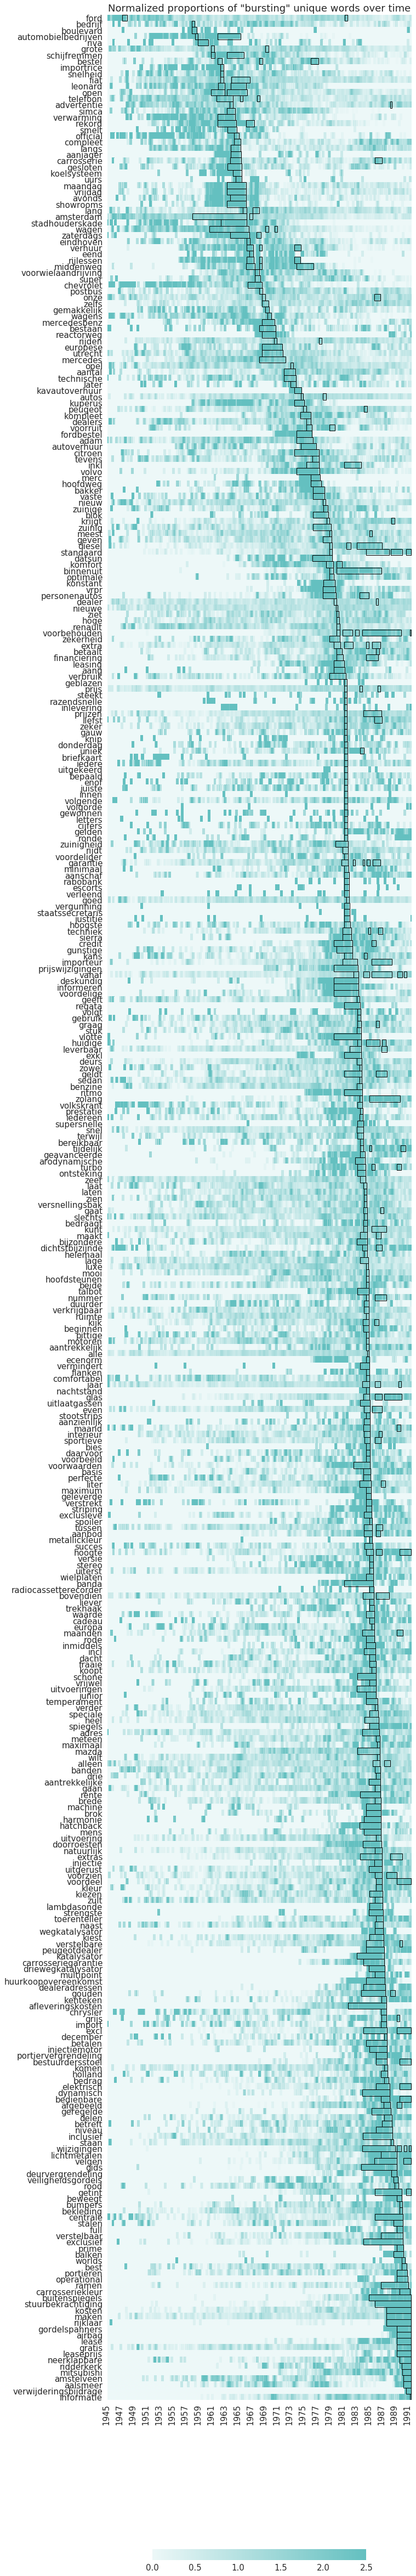

In [657]:
visualize_bursts(500, bursts_unique, unique_words, 'unique')


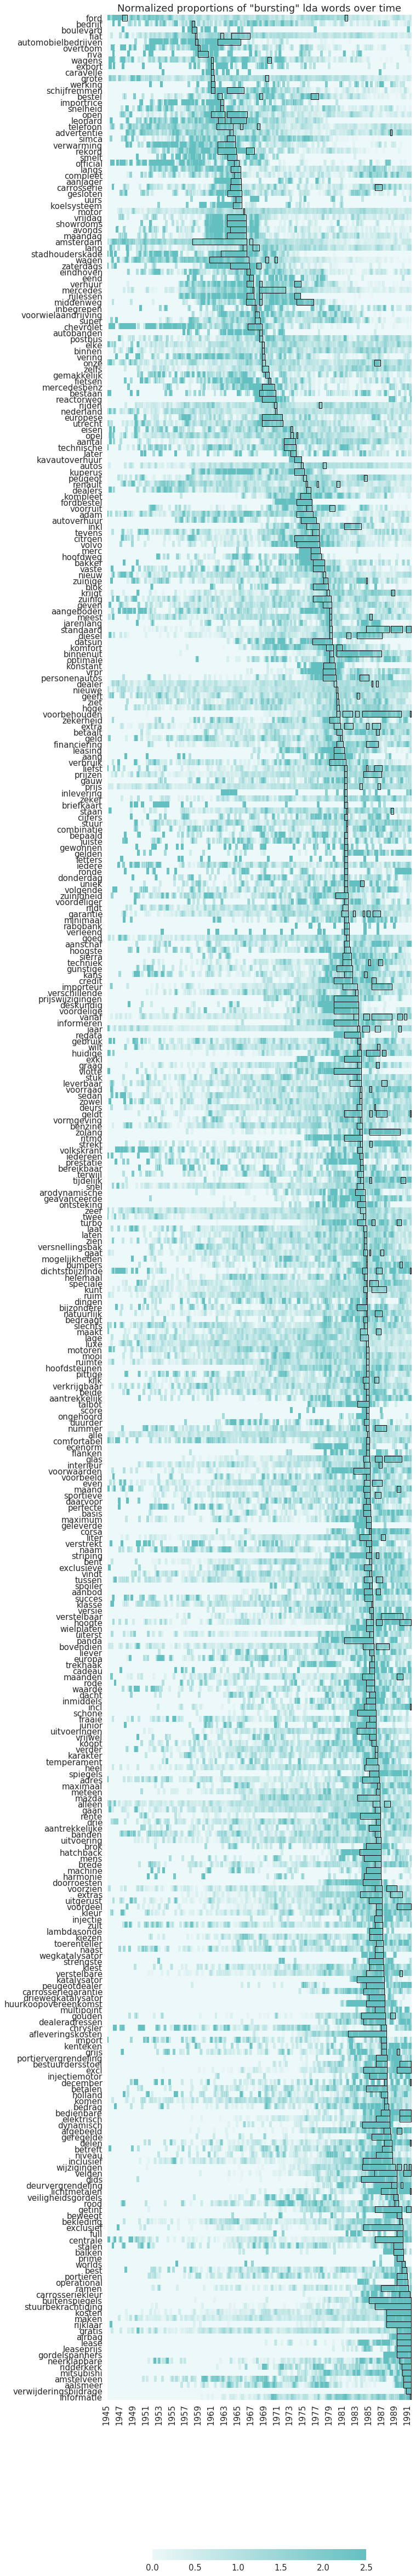

In [605]:
visualize_bursts(500, bursts_lda, all_lda_words, 'lda')

# KLD

In [45]:
# concatenate all others on front page in one document
#df['text'] = df[['date', 'ocr_clean']].groupby(pd.Grouper(freq='D'))['ocr_clean'].transform(lambda x: ' '.join(x.astype(str)))
car_df['date'] = car_df['date'].astype('datetime64[ns]')
car_df['date'] = pd.to_datetime(car_df.date, format='%Y-%m-%d')   
car_df.index = car_df['date']
car_df['year'] = car_df.date.dt.year

In [46]:
# Merge ads per day
car_df = car_df.copy()
car_df['text'] = car_df[['date', 'ocr_clean']].groupby(pd.Grouper(freq='D'))['ocr_clean'].transform(lambda x: ' '.join(x))
car_df['text'] = car_df['text'].drop_duplicates()
car_df = car_df.dropna()

In [47]:
len(car_df)

13850

In [668]:
#n_features = 10000
stop_words = set(stopwords.words('dutch'))

K = 100

docs = np.array(car_df_week['text'])

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=None, stop_words=stop_words)
X = tf_vectorizer.fit_transform(docs)
vocab = tf_vectorizer.get_feature_names()

model = lda.LDA(n_topics=K, random_state=1234)
model.fit(X)

INFO:lda:n_documents: 13850
INFO:lda:vocab_size: 87895
INFO:lda:n_words: 4093360
INFO:lda:n_topics: 100
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -61974940
INFO:lda:<10> log likelihood: -41386154
INFO:lda:<20> log likelihood: -38563790
INFO:lda:<30> log likelihood: -37603990
INFO:lda:<40> log likelihood: -37069880
INFO:lda:<50> log likelihood: -36728300
INFO:lda:<60> log likelihood: -36477359
INFO:lda:<70> log likelihood: -36273992
INFO:lda:<80> log likelihood: -36121998
INFO:lda:<90> log likelihood: -35997331
INFO:lda:<100> log likelihood: -35896042
INFO:lda:<110> log likelihood: -35811935
INFO:lda:<120> log likelihood: -35734829
INFO:lda:<130> log likelihood: -35668832
INFO:lda:<140> log likelihood: -35611677
INFO:lda:<150> log likelihood: -35558645
INFO:lda:<160> log likelihood: -35511624
INFO:lda:<170> log likelihood: -35478101
INFO:lda:<180> log likelihood: -35441107
INFO:lda:<190> log likelihood: -35406542
INFO:lda:<200> log likelihood: -35375531
INFO:lda:<210> log likel

INFO:lda:<1950> log likelihood: -34994641
INFO:lda:<1960> log likelihood: -34990874
INFO:lda:<1970> log likelihood: -34989280
INFO:lda:<1980> log likelihood: -34989643
INFO:lda:<1990> log likelihood: -34988455
INFO:lda:<1999> log likelihood: -34986960


In [49]:
path = 'models/topic_models/'

In [50]:
with open(path + 'D_K_100_vocab.sav', 'rb') as pickle_file:
    vocab = pickle.load(pickle_file)

with open(path + 'D_K_100_model.sav', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [43]:
pickle.dump(vocab, open(path + 'D_K_100_vocab.sav', 'wb'))
pickle.dump(model, open(path + 'D_K_100_model.sav', 'wb'))
print("Model Saved!!")

Model Saved!!


In [51]:
topic_word = model.topic_word_
#n = 15
#for i, topic_dist in enumerate(topic_word):
#    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
#    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))


doc_topic = model.doc_topic_
print("type(doc_topic): {}".format(type(doc_topic)))
print("shape: {}".format(doc_topic.shape))

type(doc_topic): <class 'numpy.ndarray'>
shape: (13850, 100)


In [33]:
entropies = []
dates = []
for i in range(0, doc_topic.shape[0]):
    dates.append(car_df.iloc[i]['date'])
    entropy = KLD(doc_topic[i], doc_topic[i-1])
    entropies.append(entropy)
df_entropy = pd.DataFrame(list(zip(dates, entropies)),
              columns=['ds','y'])

In [34]:
kld_ = np.zeros(len(doc_topic))    
for i in range(1,len(doc_topic)):
    submat = doc_topic[0:i,]
    tmp = np.zeros(len(submat))
    for ii in range(len(submat)):
        tmp[ii] = KLD(submat[ii,],doc_topic[i,])
    kld_[i] = np.mean(tmp)    
entropies_sum = kld_-np.mean(kld_)

In [35]:
entropy_sum = pd.DataFrame(list(zip(dates, entropies_sum)),
              columns=['ds','y'])

In [20]:
df_entropy = df_entropy.reset_index('ds')

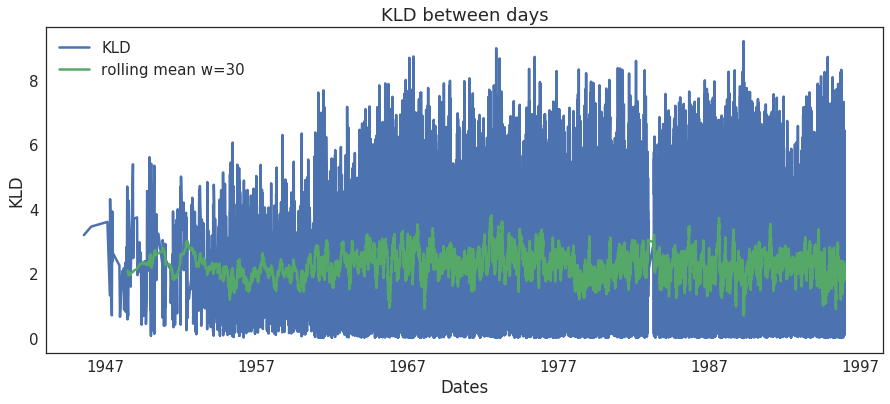

In [48]:
y = df_entropy['y'].rolling(30).mean()
plt.plot(df_entropy['ds'], df_entropy['y'], label='KLD')
plt.plot(df_entropy['ds'], y, label='rolling mean w=30')
plt.ylabel('KLD')
plt.xlabel('Dates')
plt.legend()
plt.title('KLD between days')
plt.savefig('figures/kld_days.png')

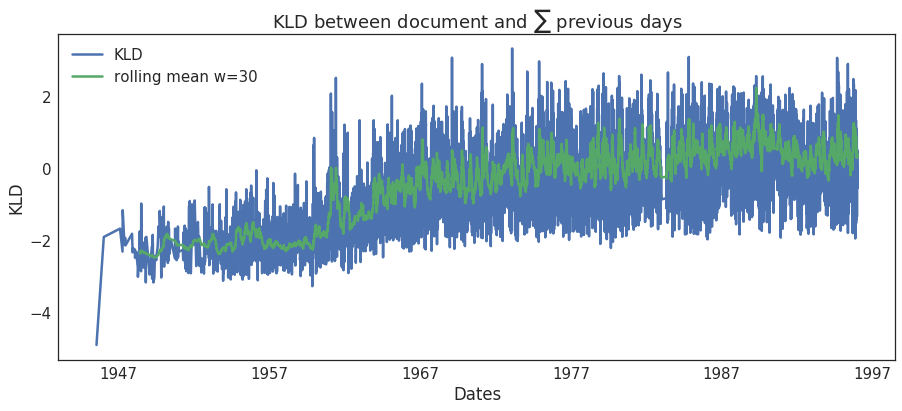

In [58]:
y = entropy_sum['y'].rolling(30).mean()
plt.plot(entropy_sum['ds'], entropy_sum['y'], label='KLD')
plt.plot(entropy_sum['ds'], y, label='rolling mean w=30')
plt.ylabel('KLD')
plt.xlabel('Dates')
plt.legend()
plt.title('KLD between document and $\sum$ previous days')
plt.savefig('figures/kld_sum_days.png')

In [ ]:
# resampling time series
df_entropy = df_entropy.set_index('ds').resample('M').apply(np.mean)
df_entropy.index = df_entropy.index - pd.offsets.MonthBegin(1) #return beginning of month
df_entropy.reset_index(inplace=True)

In [59]:
car_df.shape[0]

13850

In [27]:
time_range = [1, 7]

In [60]:
entropies = []
dates = []
for i in range(7, doc_topic.shape[0] - 7):
    dates.append(car_df.iloc[i]['date'])
    time_range = range(-7 , 7)
    w = (len(time_range))
    KLDs = []
    for d in time_range:
        KLDs.append(KLD(doc_topic[i], doc_topic[i + d]))
    avg_KLD = 1/w * np.sum(KLDs)
    entropies.append(avg_KLD)
df_entropy_week = pd.DataFrame(list(zip(dates, entropies)),
              columns=['ds','y'])

In [30]:
df_entropy_week = df_entropy_week.set_index('ds')

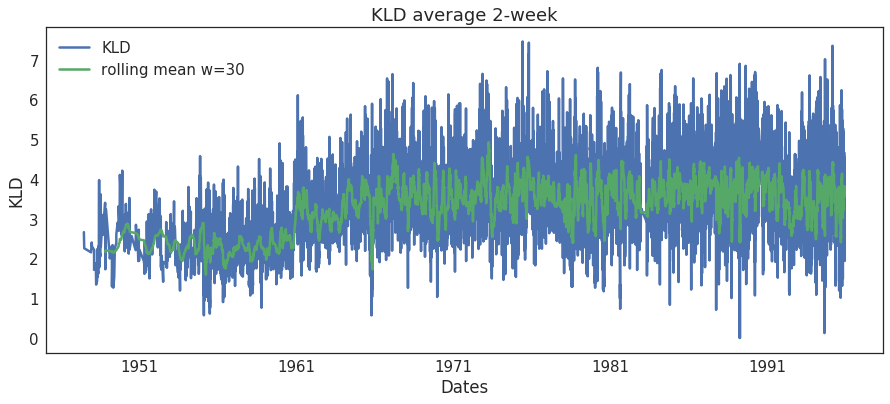

In [64]:
y = df_entropy_week['y'].rolling(30).mean()
plt.plot(df_entropy_week['ds'], df_entropy_week['y'], label='KLD')
plt.plot(df_entropy_week['ds'], y, label='rolling mean w=30')
plt.ylabel('KLD')
plt.xlabel('Dates')
plt.legend()
plt.title('KLD average 2-week')
plt.savefig('figures/kld_avg_week.png')

In [14]:
##car_df_week chnaged to car_df

jump_entropies_ = []
baseline_entropies_ = []
dates = []
jump_size = []

#jumps = chain(range(30, 360, 7), range(361, 540, 14), range(540,1000, 30))


for jump in range(30, 1000, 10):
    print("jump size: {}".format(jump))
    for i in range(jump, doc_topic.shape[0] - jump):
    #for i in range(jump, 2000 - jump):
        dates.append(car_df.iloc[i]['date'])
        jump_size.append(jump)
        time_range = range(-7, 7)
        w = (len(time_range))
        jump_entropies = []
        baseline_entropies = []
        for d in time_range:
            baseline_entropies.append(KLD(doc_topic[i], doc_topic[i+d]))
            jump_entropies.append(KLD(doc_topic[i + d], doc_topic[(i - jump) + d]))
        avg_jump_entropies = 1/w * np.sum(jump_entropies)
        avg_baseline_entropies = 1/w * np.sum(baseline_entropies)
        baseline_entropies_.append(avg_baseline_entropies)
        jump_entropies_.append(avg_jump_entropies)
    difference = [a - b for a, b in zip(jump_entropies_, baseline_entropies_)]
    difference = np.array(difference)
    df_kld = pd.DataFrame(list(zip(dates, baseline_entropies_ ,jump_entropies_, difference)),
              columns=['dates', 'baseline_entropies', 'jump_entropies_', 'difference'])
    df_kld['jump_size'] = jump_size 

jump size: 30
jump size: 40
jump size: 50
jump size: 60
jump size: 70
jump size: 80
jump size: 90
jump size: 100
jump size: 110
jump size: 120
jump size: 130
jump size: 140
jump size: 150
jump size: 160
jump size: 170
jump size: 180
jump size: 190
jump size: 200
jump size: 210
jump size: 220
jump size: 230
jump size: 240
jump size: 250
jump size: 260
jump size: 270
jump size: 280
jump size: 290
jump size: 300
jump size: 310
jump size: 320
jump size: 330
jump size: 340
jump size: 350
jump size: 360
jump size: 370
jump size: 380
jump size: 390
jump size: 400
jump size: 410
jump size: 420
jump size: 430
jump size: 440
jump size: 450
jump size: 460
jump size: 470
jump size: 480
jump size: 490
jump size: 500
jump size: 510
jump size: 520
jump size: 530
jump size: 540
jump size: 550
jump size: 560
jump size: 570
jump size: 580
jump size: 590
jump size: 600
jump size: 610
jump size: 620
jump size: 630
jump size: 640
jump size: 650
jump size: 660
jump size: 670
jump size: 680
jump size: 690
ju

In [15]:
df_kld = df_kld.set_index('dates')

In [20]:
df_kld.to_pickle('df_kld.pkl')

In [50]:
df_kld = pd.read_pickle('df_kld.pkl')

In [155]:
df_kld = df_kld.reset_index()

In [16]:
idx = df_kld.groupby(['dates'])['difference'].transform(min) == df_kld['difference']
df_kld_min = df_kld[idx]

idx = df_kld.groupby(['dates'])['difference'].transform(max) == df_kld['difference']
df_kld_max = df_kld[idx]

In [41]:
df_kld = df_kld.reset_index()

In [95]:
means = df_kld.groupby(['dates'])['difference'].mean()
df_kld_avg = df_kld.ix[(df_kld['difference']-means).abs().argsort()]

In [96]:
df_kld_avg = df_kld_avg.reset_index().drop_duplicates(['dates'], keep='first')

In [98]:
df_kld_avg = df_kld_avg.set_index('dates')

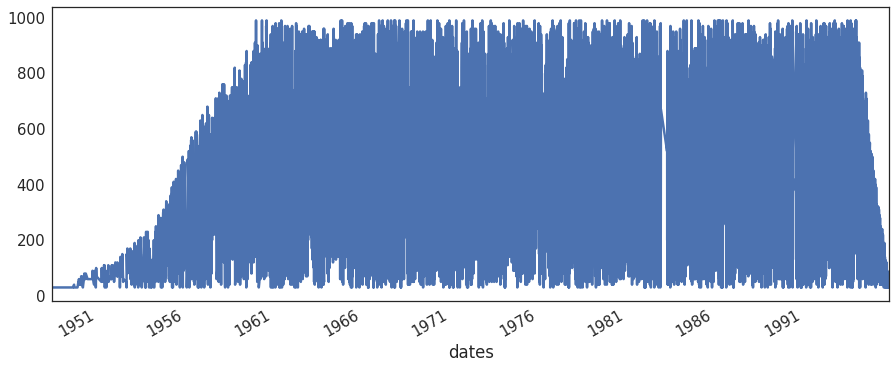

In [99]:
df_kld_avg['jump_size'].plot()

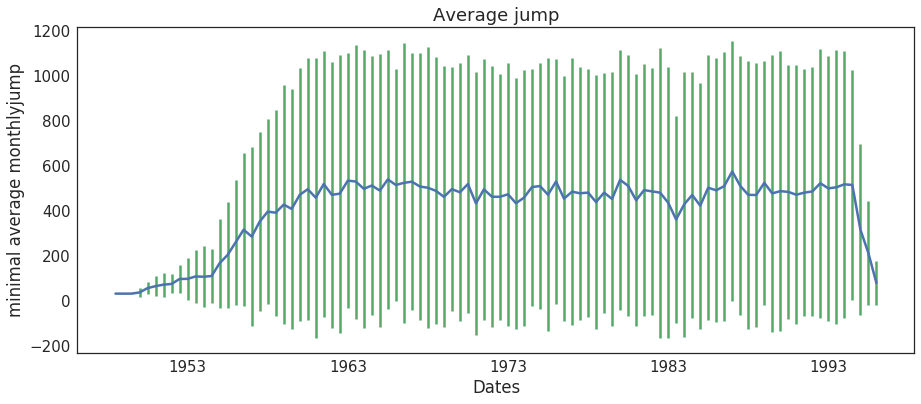

In [105]:
mean = df_kld_avg['jump_size'].groupby(pd.TimeGrouper('6M')).mean()
std = df_kld_avg['jump_size'].groupby(pd.TimeGrouper('6M')).std()
plt.plot(mean)
plt.errorbar(mean.index, mean, yerr=2*std, linestyle='')
plt.ylabel('minimal average monthlyjump')
plt.xlabel('Dates')
plt.title('Average jump')
plt.savefig('average_jump.png')

In [203]:
jumps = df_kld.groupby(['dates', 'jump_size'])['difference'].mean().index.get_level_values(1)

In [77]:
df_avg_jump = df_kld.reset_index().sort_values('difference', ascending=False).drop_duplicates('dates')
df_avg_jump = df_avg_jump.set_index('dates')

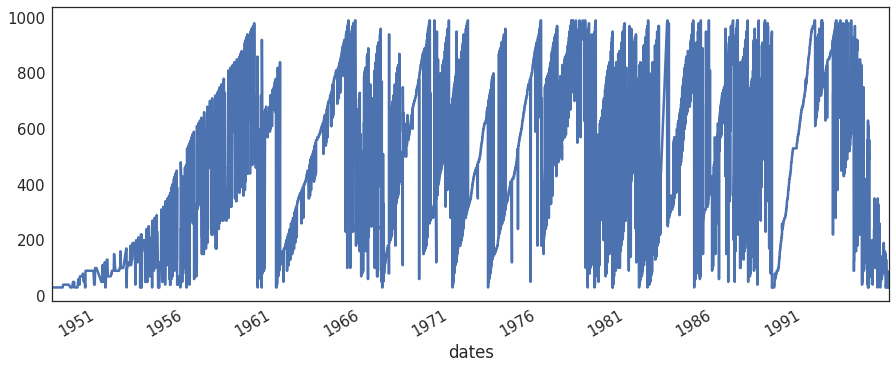

In [78]:
df_avg_jump['jump_size'].plot()

In [54]:
df_grouped

dates
1948-06-26    1.913548
1948-07-03    1.871047
1948-07-08    0.337990
1948-07-12    1.328211
1948-08-28    0.342623
1948-08-31    0.798838
1948-10-21   -0.064378
1948-10-27    1.503399
1948-11-11   -0.169900
1949-01-29    0.721310
1949-02-07    0.879967
1949-03-28    0.526985
1949-03-30    1.325792
1949-04-12    0.252878
1949-04-29    1.070111
1949-05-21    0.688794
1949-06-04   -0.128009
1949-07-09   -0.154060
1949-07-09   -0.154060
1949-08-10   -0.412229
1949-08-31   -0.295735
1949-09-01   -0.847245
1949-09-22    0.061461
1949-09-24    0.139986
1949-09-29   -0.941093
1949-10-28   -0.175724
1949-11-05    0.941428
1949-11-07    0.815470
1949-11-24   -0.536267
1949-12-02    0.764885
                ...   
1993-12-18    0.765278
1993-12-20    1.580510
1993-12-21    0.949432
1993-12-21    0.949432
1993-12-22    1.776098
1993-12-24    1.901474
1993-12-24    1.901474
1993-12-24    1.901474
1993-12-27   -0.916140
1993-12-28    0.837976
1993-12-28    0.837976
1993-12-30    1.735617
1993-

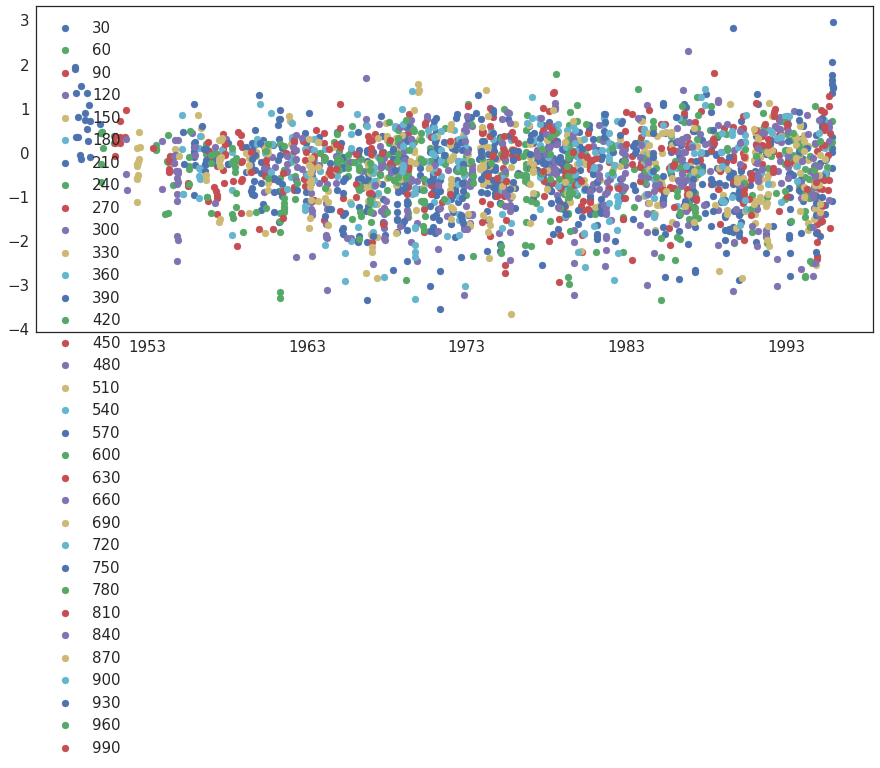

In [22]:
for jump in range(30, 1000, 30):
    y = df_kld_min['difference'][df_kld_min['jump_size'] == jump]
    x = df_kld_min.index[df_kld_min['jump_size'] == jump]
    plt.scatter(x, y, label=jump, marker='o')
    plt.legend()

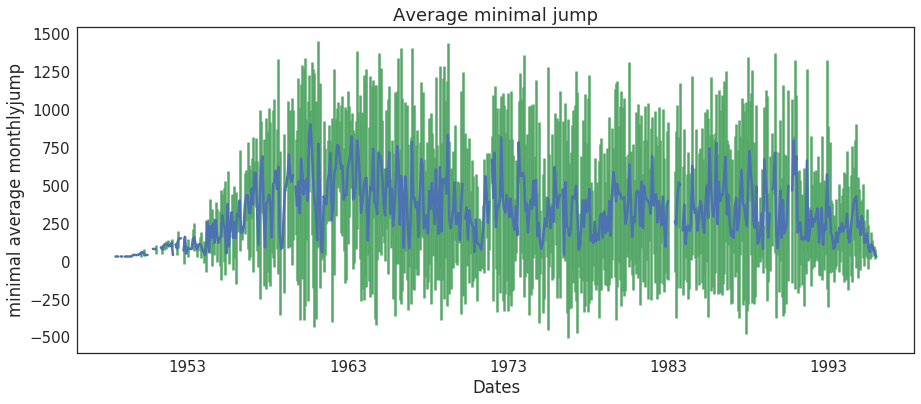

In [219]:
mean = df_kld_min['jump_size'].groupby(pd.TimeGrouper('M')).mean()
std = df_kld_min['jump_size'].groupby(pd.TimeGrouper('M')).std()
plt.plot(mean)
plt.errorbar(mean.index, mean, yerr=2*std, linestyle='')
plt.ylabel('minimal average monthlyjump')
plt.xlabel('Dates')
plt.title('Average minimal jump')
plt.savefig('min_month_jump.png')

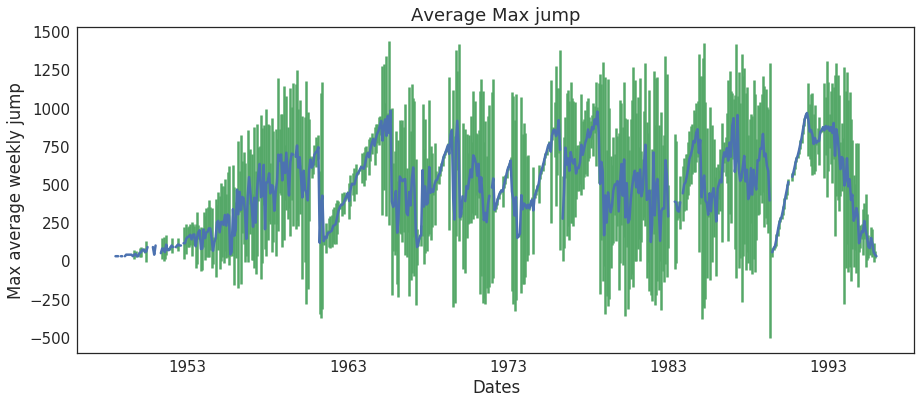

In [220]:
mean = df_kld_max['jump_size'].groupby(pd.TimeGrouper('M')).mean()
std = df_kld_max['jump_size'].groupby(pd.TimeGrouper('M')).std()
plt.plot(mean)
plt.errorbar(mean.index, mean, yerr=2*std, linestyle='')
plt.ylabel('Max average weekly jump')
plt.xlabel('Dates')
plt.title('Average Max jump')
plt.savefig('max_month_jump.png')

<ErrorbarContainer object of 3 artists>

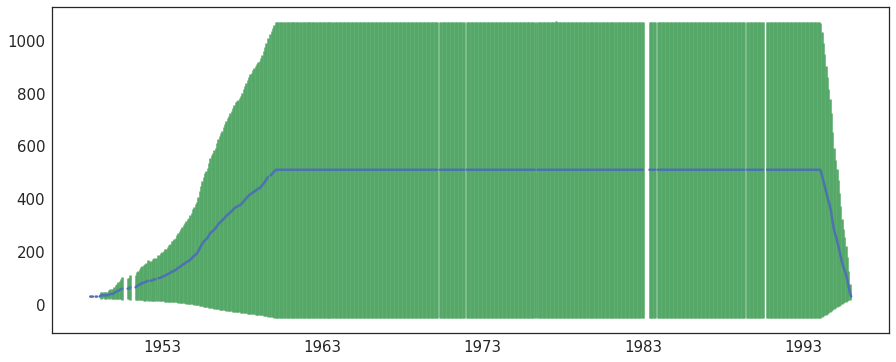

In [115]:
mean = df_kld['jump_size'].groupby(pd.TimeGrouper('M')).mean()
std = df_kld['jump_size'].groupby(pd.TimeGrouper('M')).std()
plt.plot(mean)
plt.errorbar(mean.index, mean, yerr=2*std, linestyle='')

In [143]:
def calculate(dataframe):
    dates = []
    novelty = []
    transience = []
    resonance = []
    time_frame = []
    for w in chain(range(1, 30, 1), range(31, 540, 30)):
        print(w)
        for i in range(w, doc_topic.shape[0] - w ):
            time_frame.append(w)
            avg_transience = 0
            avg_novelty = 0
            dates.append(dataframe.iloc[i]['date'])
            novelties = []
            transiences = []
            for d in range(1, w+1):
                novelties.append(KLD(doc_topic[i], doc_topic[i-d]))
                transiences.append(KLD(doc_topic[i], doc_topic[i+d]))
            avg_novelty = 1/w * np.sum(novelties)
            avg_transience = 1/w * np.sum(transiences)
            transience.append(avg_transience)
            novelty.append(avg_novelty)
        resonance = [a - b for a, b in zip(novelty, transience)]
        resonance = np.array(resonance)
            
    df_kld = pd.DataFrame(list(zip(transience, novelty, resonance)),
              columns=['transience','novelty', 'resonance'])
    df_kld['time_frame'] = time_frame
    df_kld['dates'] = dates
    df_kld.to_pickle('df_kld_final.pkl')
    return df_kld

In [144]:
df_kld_window = calculate(car_df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
31
61
91
121
151
181
211
241
271
301
331
361
391
421
451
481
511


In [ ]:
df_kld.to_pickle('df_kld_k_50_final.pkl')
#df_kld = pd.read_pickle('df_kld_k_50_final.pkl')

In [145]:
df_kld_window.reset_index(inplace=True)

In [146]:
df_kld_window['year'] = df_kld_window.dates.dt.year

In [147]:
from scipy.stats import zscore
numeric_cols = ['transience', 'novelty', 'resonance']
df_kld_window[['transience-z', 'novelty-z', 'resonance-z']] = df_kld_window[numeric_cols].apply(zscore)
df_kld_window = df_kld_window.set_index('dates')

In [148]:
df_kld_2 = pd.melt(df_kld_window, id_vars=['time_frame'], value_vars=['transience', 'novelty'])

In [149]:
mask = df_kld_2['variable'] == 'transience'
df_kld_2.loc[mask, 'time_frame'] = df_kld_2.loc[mask, 'time_frame'] * -1



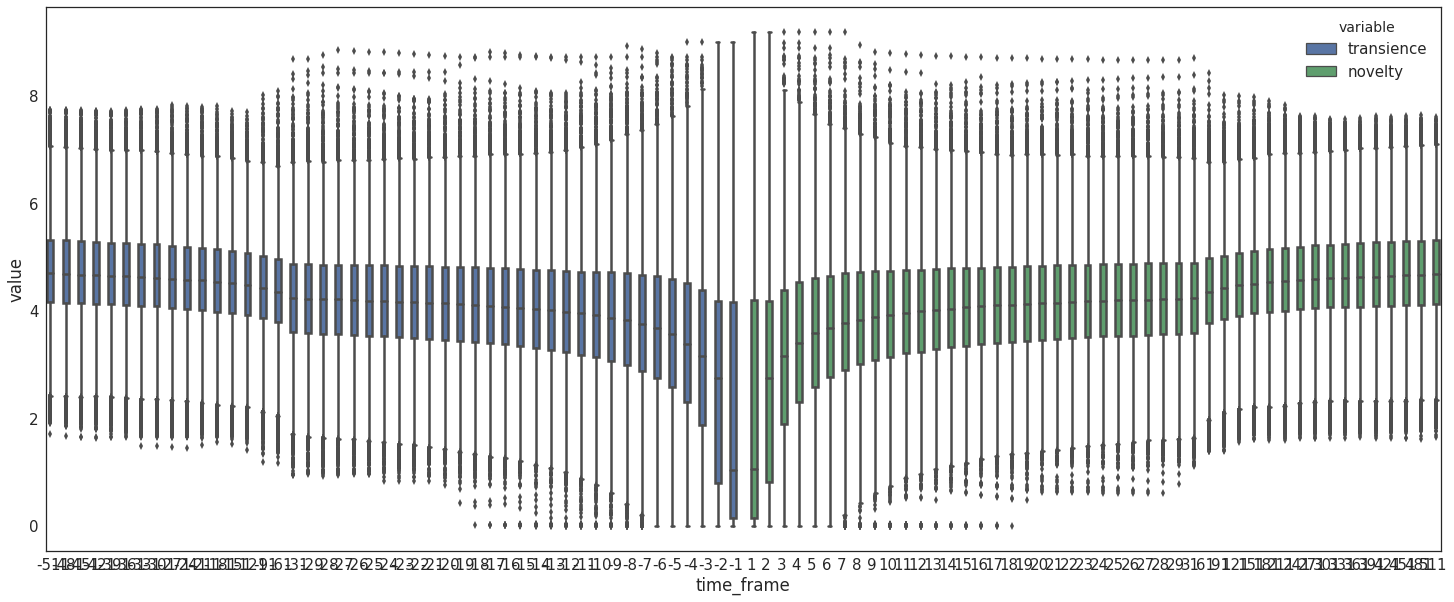

In [150]:
fig = plt.figure(figsize=(25,10))
ax = sns.boxplot(x="time_frame", y="value", hue='variable', data=df_kld_2, linewidth=2.5)

In [189]:
time_range = chain(range(1, 30, 1), range(31, 540, 30))
#novelties = []
#for w in [10, 31, 101, 301]:
#    novelties.append(df_kld_window['novelty'][df_kld_window['time_frame'] == w].resample('M').apply(np.mean))


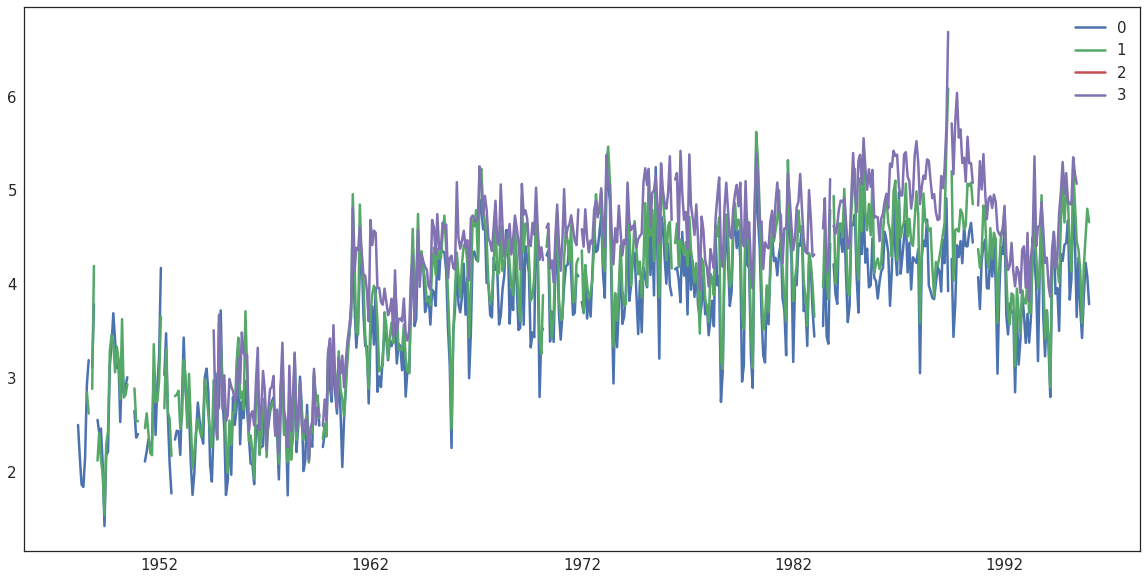

In [172]:
plt.figure(figsize=(20,10))
for i, novelty in enumerate(novelties):
    plt.plot(novelty, label=i)
    plt.legend()

Decreased differences between lines on all time-scales suggest that innovation breaks with all tradition, long or short. Also differences in novelty decrease with time scale. 

In [182]:
import seaborn as sns
for w in time_range:
    novelty = df_kld_window['novelty'][df_kld_window['time_frame'] == w]
    transience = df_kld_window['transience'][df_kld_window['time_frame'] == w]
    #g = sns.jointplot(novelty, transience, kind='hex', xlim=[-7,7], ylim=[-7,7])
    g = sns.jointplot(novelty, transience, kind='reg')
    #plt.plot(range(0, 10), range(0,10))
    plt.title('Time Scale {}'.format(w), y=1.20)
    plt.show()

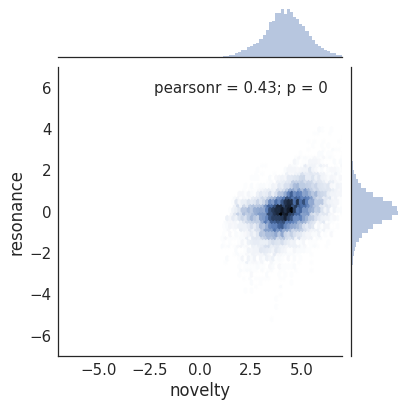

In [186]:
novelty = df_kld_window['novelty'][df_kld_window['time_frame'] == 31]
resonance = df_kld_window['resonance'][df_kld_window['time_frame'] == 31]
g = sns.jointplot(novelty, resonance, kind='hex', xlim=[-7,7], ylim=[-7,7])

Speeches close to symmetry line are symmetric in suprise from past and from the future. 
The trend line goes up meaning that speeches that are innovative compared to speeches from before are more likely to be transient. 

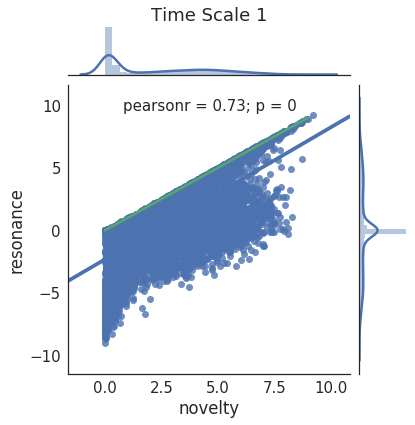

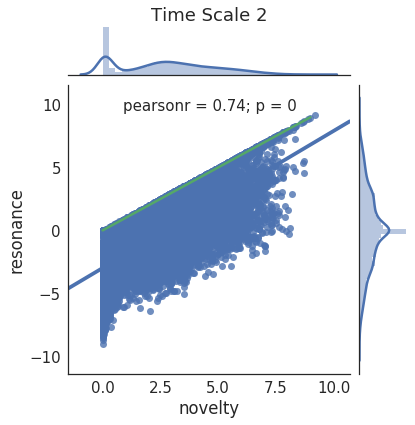

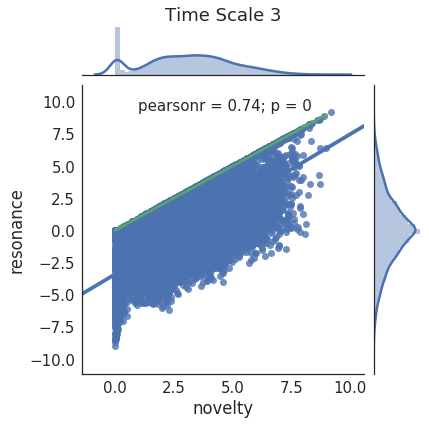

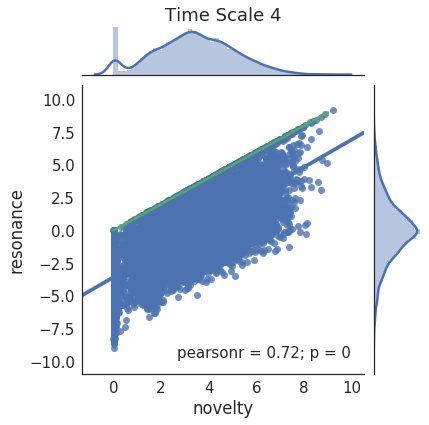

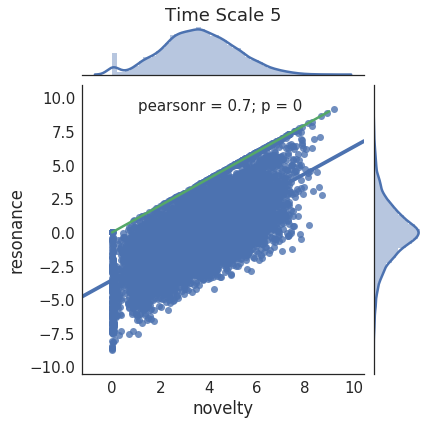

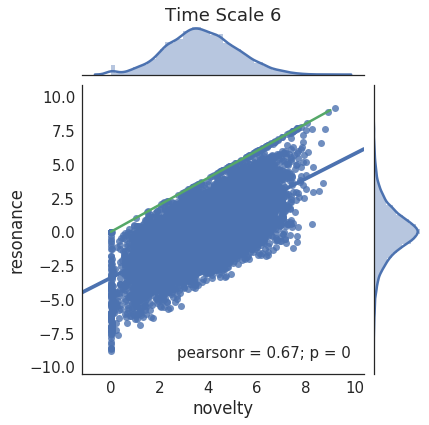

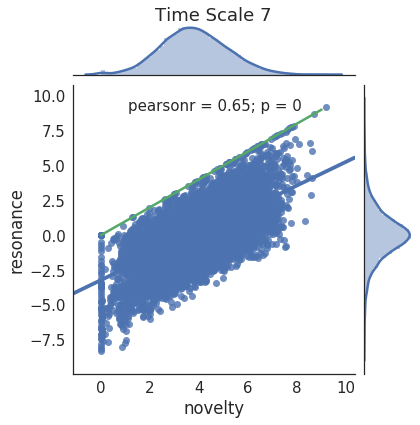

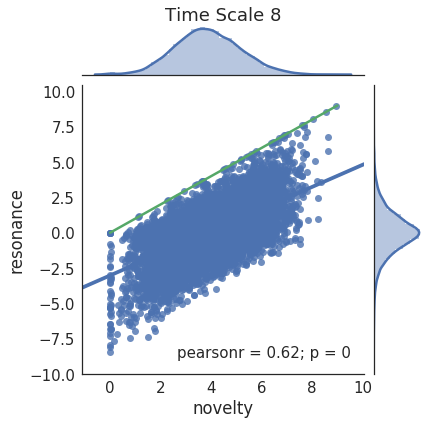

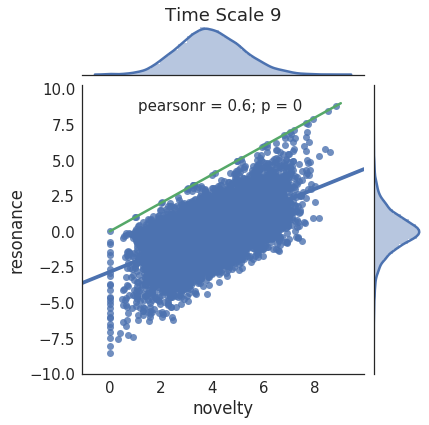

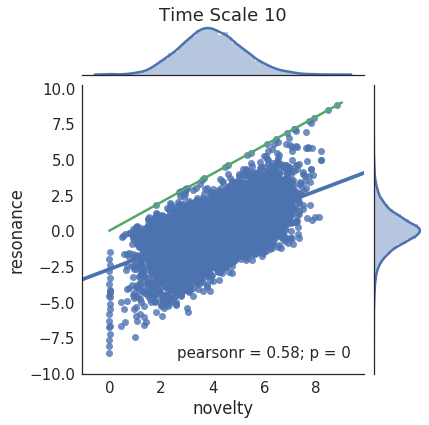

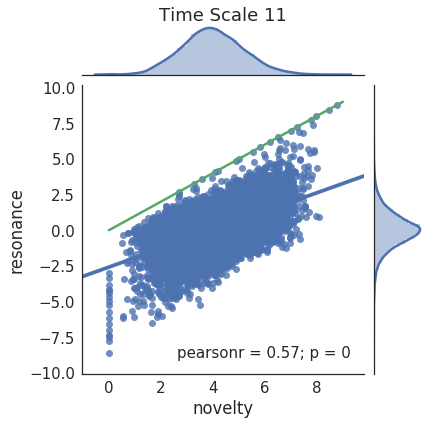

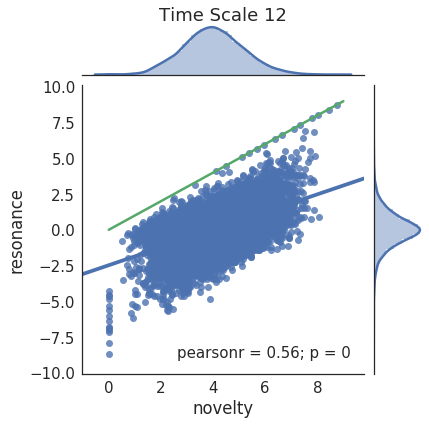

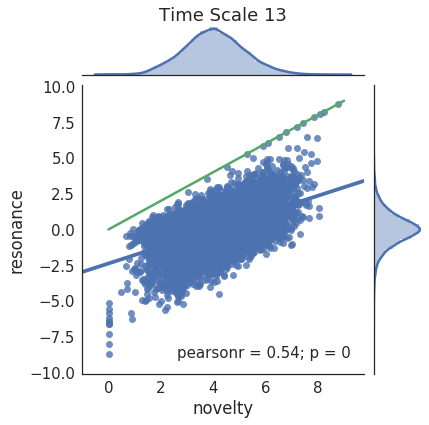

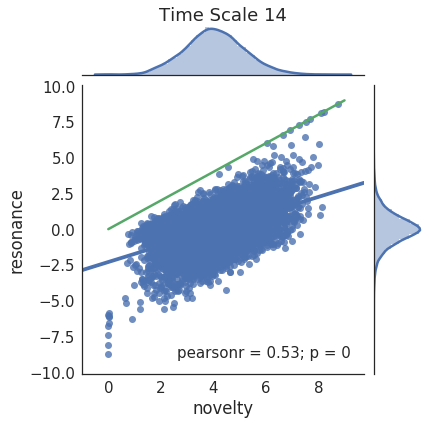

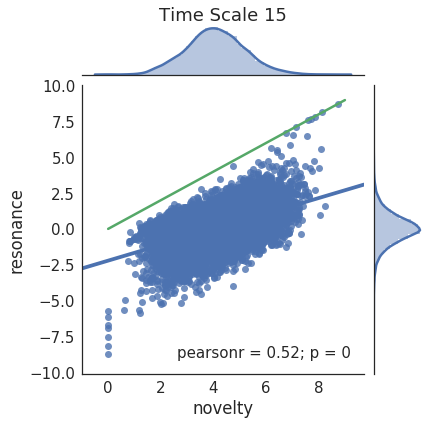

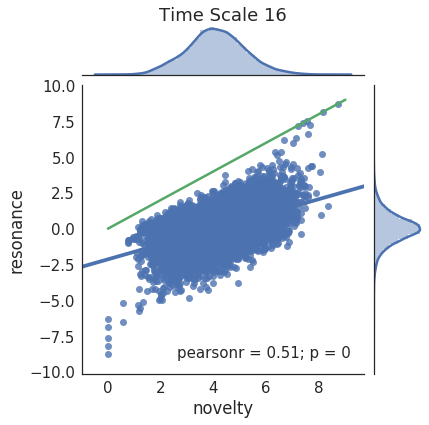

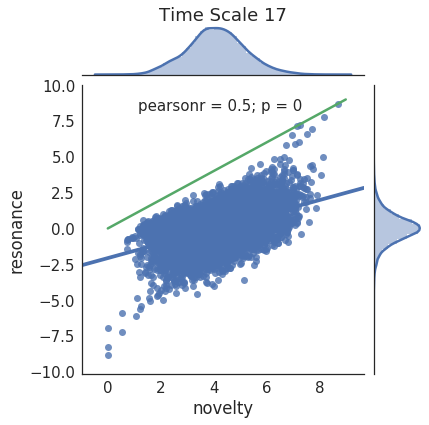

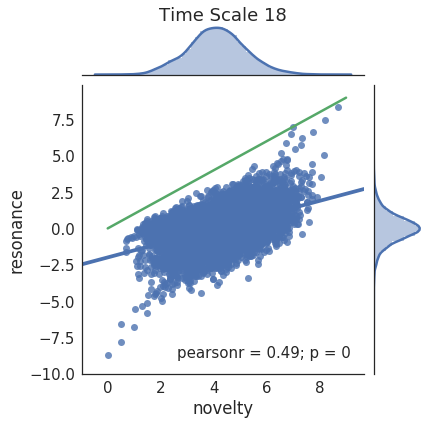

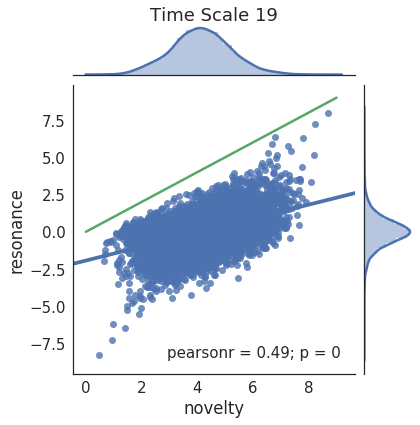

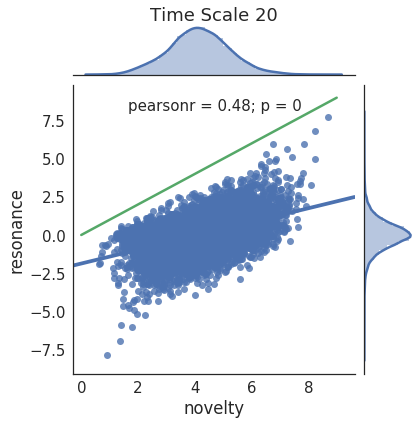

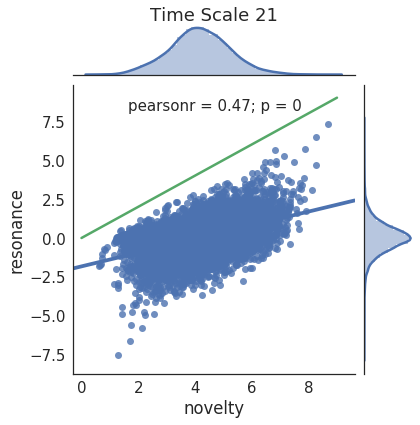

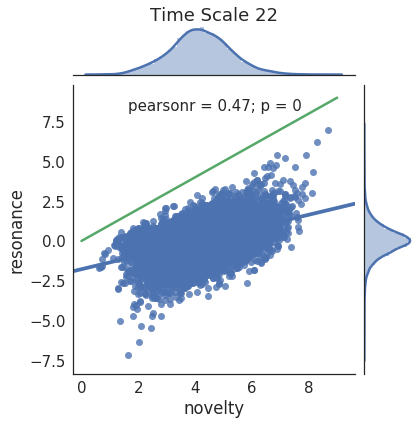

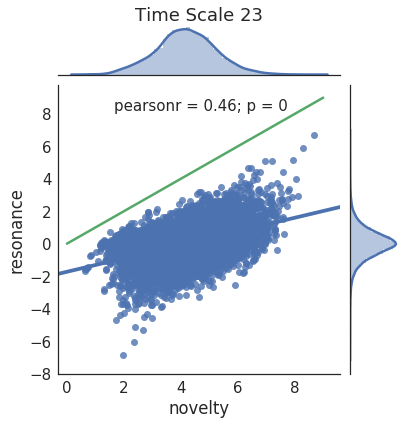

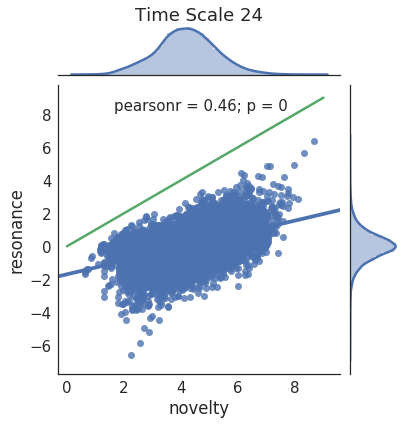

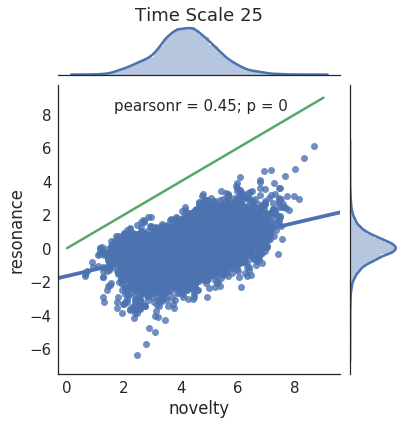

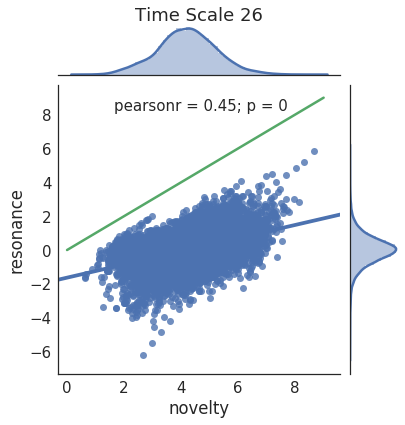

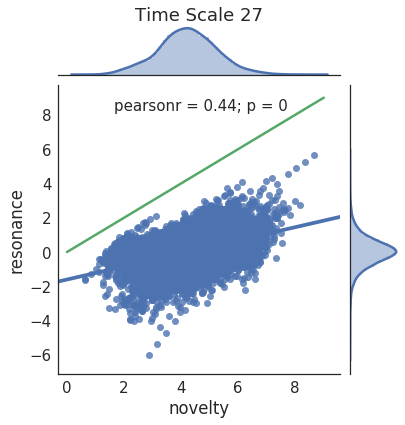

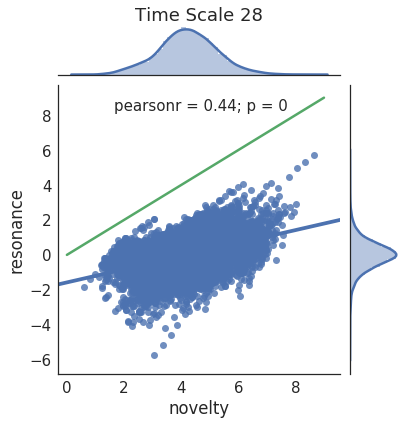

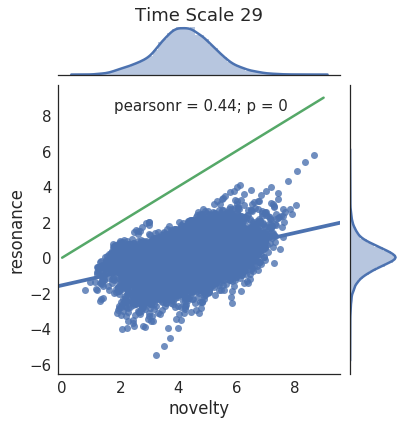

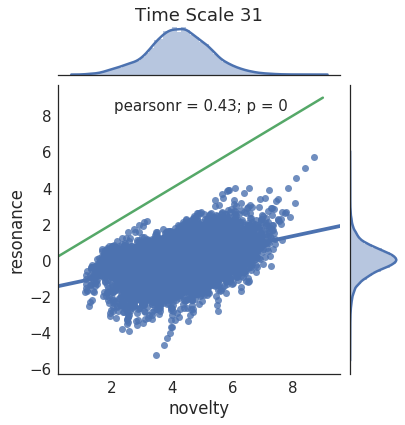

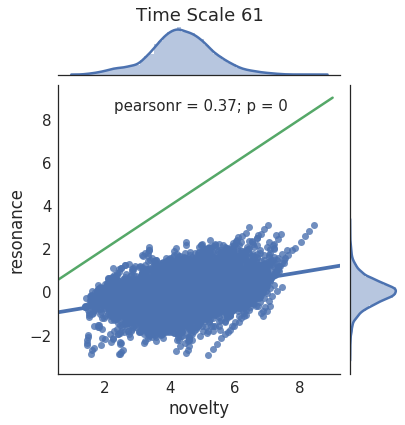

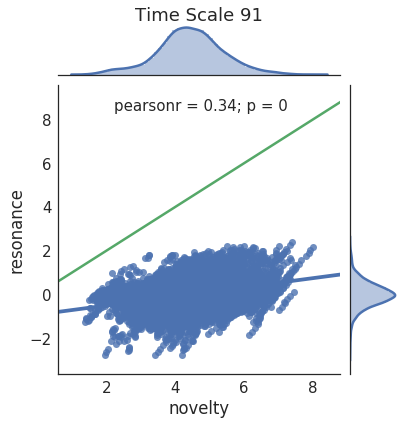

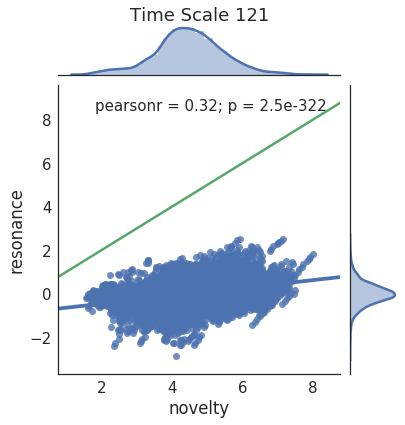

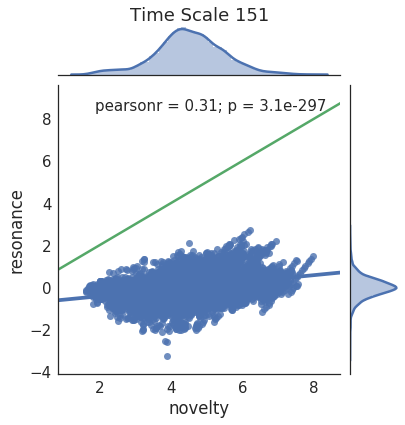

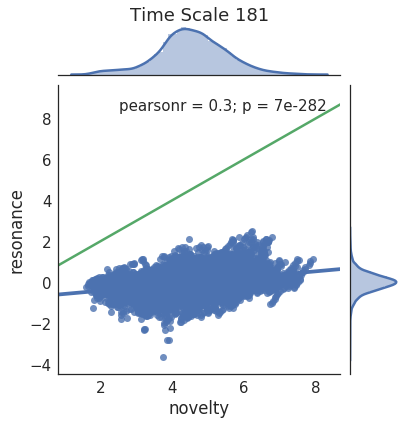

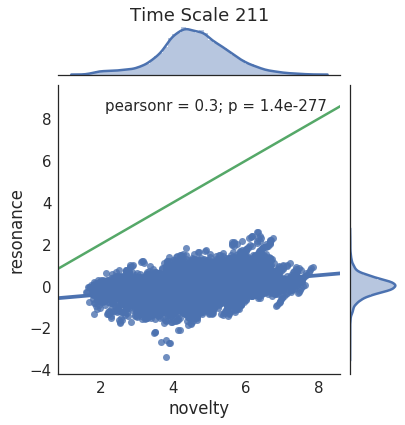

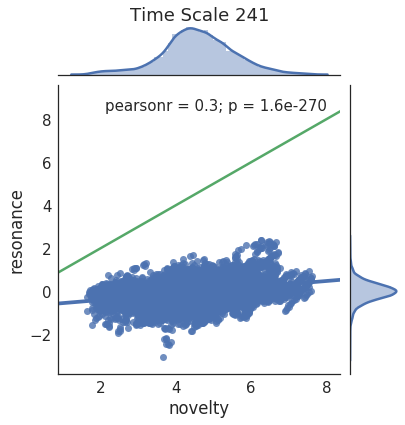

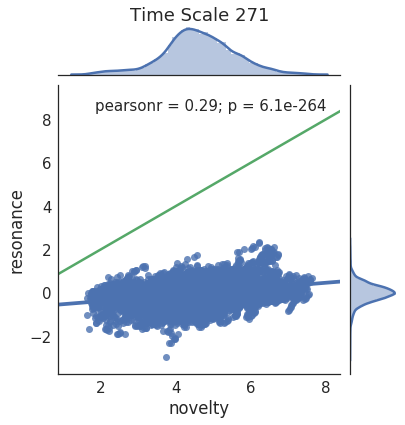

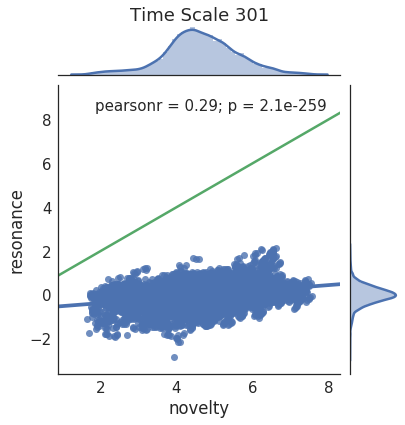

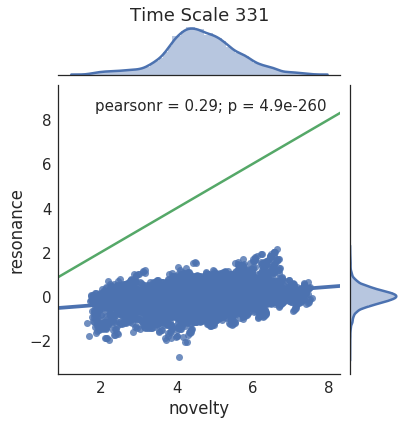

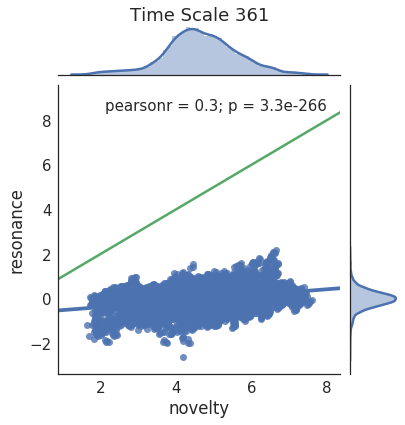

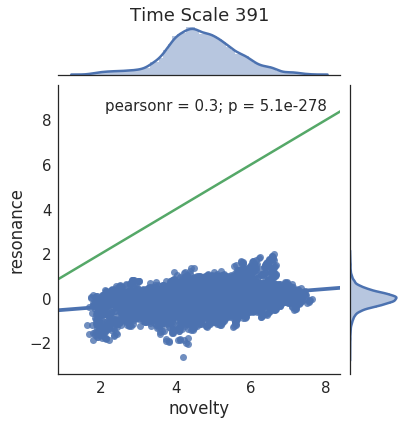

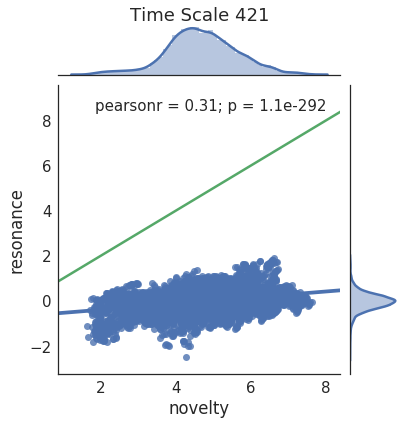

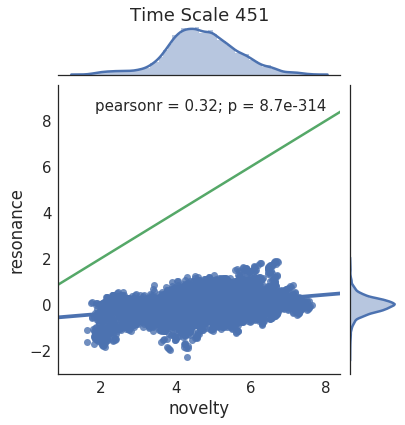

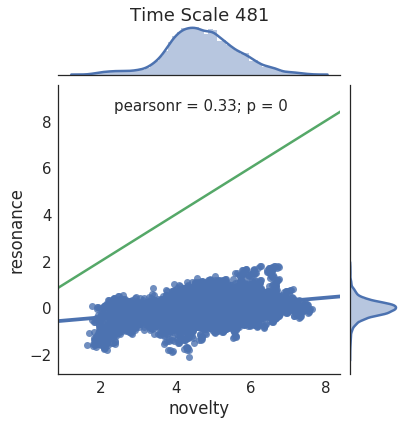

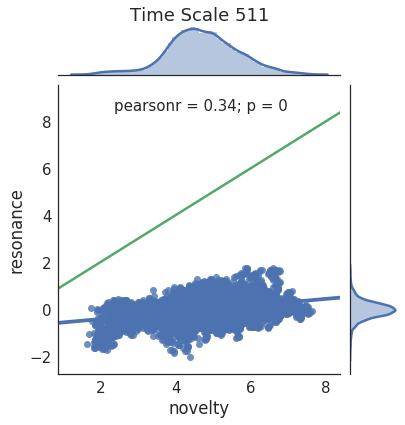

In [190]:
'''
Resonance, the quality of at once breaking from the past and influencing the future
'''
for w in time_range:
    novelty = df_kld_window['novelty'][df_kld_window['time_frame'] == w]
    resonance = df_kld_window['resonance'][df_kld_window['time_frame'] == w]
    #g = sns.jointplot(novelty, transience, kind='hex', xlim=[-7,7], ylim=[-7,7])
    ax = sns.jointplot(novelty, resonance, kind="reg")
    plt.plot(range(0, 10), range(0,10))
    plt.title('Time Scale {}'.format(w), y=1.20)

In [191]:
import statsmodels.formula.api as sm

maximizing resonance > the power to influence conversation > expected resonance of speech. Novelty effectiviness Gamma.

In [196]:
time_range = chain(range(1, 30, 1), range(31, 540, 30))

gammas = []
intercepts = []
w_s = []
for w in time_range:
    try:
        result = sm.ols(formula="resonance ~ novelty", data=df_kld_window[df_kld_window['time_frame'] == w]).fit()
        gamma = result.params[1]
        intercept = result.params[0]
        gammas.append(gamma)
        w_s.append(w)
        intercepts.append(intercept)
    except:
        pass
gamma_df = pd.DataFrame(list(zip(w_s, intercepts, gammas)),
                        columns=['scales', 'intercept', 'gamma'])

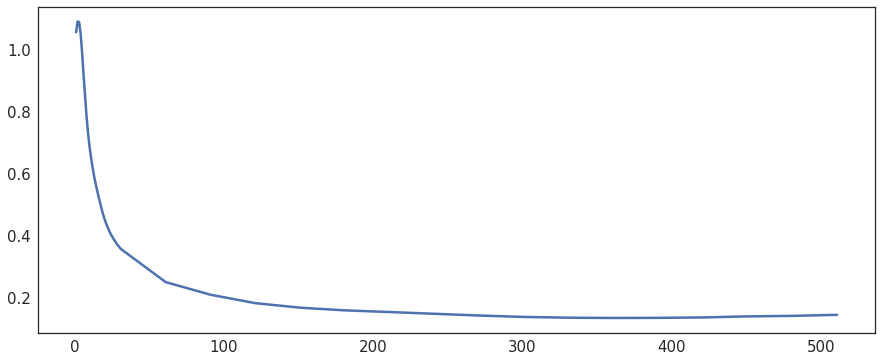

In [200]:
X = gamma_df['scales']
y = gamma_df['gamma']
plt.plot(X, y)

In [ ]:
y

In [ ]:
df_kld

In [204]:
#mean_novelties = {}
mean_resonance = {}
#mean_transience = {}
for w in df_kld_window['time_frame']:
    #mean_novelties[w] = df_kld_window['novelty'][df_kld_window['time_frame'] == w].mean()
    #mean_transience[w] = df_kld_window['transience'][df_kld_window['time_frame'] == w].mean()
    mean_resonance[w] = df_kld_window['resonance'][df_kld_window['time_frame'] == w].mean()

KeyboardInterrupt: 

In [ ]:
scales = list(mean_resonance.keys())           
values = list(mean_resonance.values())        
plt.plot(scales, values)


## Bayesian Change Point Detection

In [ ]:
import cProfile
import sselogsumexp

In [ ]:
data = df_entropy['y']
dates_ = df_entropy['ds']

In [ ]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

In [ ]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

In [ ]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial

R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(dates_, data)
ax = fig.add_subplot(3, 1, 2)
sparsity = 5  # only plot every fifth data for faster display
#ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
#          np.array(range(0, len(R[:,0]), sparsity)), 
#          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
#          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

In [ ]:
plt.plot(R[Nw,Nw:-1])

## Gensim Topic Modeling

In [ ]:
from nltk import word_tokenize
from gensim import corpora
from gensim import models
from gensim.models import LdaModel, LdaMulticore
from multiprocessing import cpu_count
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
docs = np.array(car_df['ocr_clean'])
docs = [document.split() for document in docs]

dictionary = Dictionary(docs)
#dictionary.filter_extremes(no_below=10, no_above=.1) #very strict pruning similar to tf-idf pruning
dictionary.filter_extremes(no_below=5, no_above=.95)
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

In [ ]:
# Set training parameters.
num_topics = 16
#chunksize = 2000
passes = 20
eval_every = 5  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token


%time model = LdaModel(corpus=corpus, id2word=dictionary, alpha='auto', eta='auto', num_topics=num_topics,passes=passes, eval_every=eval_every, random_state=999)
#%time model = LdaMulticore(corpus=corpus, id2word=id2word, eta='auto', workers=cpu_count()-1, iterations=iterations, num_topics=num_topics,passes=passes, eval_every=eval_every)

In [ ]:
model = LdaModel.load('lda-k16.model')

In [ ]:
'''
Extract the top 150 words each topic and put the 150 unique words in a list
'''

topic_words = []
lda_words = []
for i in range(num_topics):
    tt = model.get_topic_terms(i,150)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    for topic in topic_words:
        for word in topic:
            if word not in lda_words:
                lda_words.append(word)

In [ ]:
len(lda_words)

In [ ]:
all_topics = []
topics = model.get_document_topics(corpus, per_word_topics=True)
all_topics = [max(doc_topics[0], key=lambda item:item[1]) for doc_topics in topics]
topic_list = []
for topic in all_topics:
    topic_x = topic[0]
    topic_list.append(topic_x)
car_df['all_topics'] = all_topics
car_df['topic'] = topic_list

In [ ]:
car_df.to_pickle('car_df_topics.pkl')

In [ ]:
#car_df = pd.read_pickle('car_df_topics.pkl')

## Evaluation topic models

In [ ]:
def evaluate_graph(dictionary, corpus, texts, begin, end, steps):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    """
    u_mass = []
    c_v = []
    lm_list = []
    for num_topics in range(begin, end, steps):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha='auto', eta='auto', iterations=500, passes=20)
        #lm = LdaMulticore(corpus=corpus, id2word=id2word, eta='auto', workers=3, iterations=500, num_topics=num_topics,passes=passes, eval_every=None)
        lm_list.append(lm)
        cm_umass = CoherenceModel(model=lm, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        cm_cv = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm_cv.get_coherence())
        u_mass.append(cm_umass.get_coherence())
        
    # Show graph
    x = range(begin, end, steps)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    # Show graph
    x = range(begin, end, steps)
    plt.plot(x, u_mass)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("u_mass"), loc='best')
    plt.show()
    
    return lm_list

In [ ]:
c_v = evaluate_graph(dictionary, corpus, docs, 5, 100, 1)

In [ ]:
lm_list

In [ ]:
c_v = []
with open('c_v.txt') as inputfile:
    for line in inputfile:
        c_v.append(line.strip().split(','))

# Show graph
    x = range(5, 100, 1)
    plt.xticks(np.arange(min(x), max(x)+5, 5.0))
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    plt.savefig('c_v.png')

u_mass = []
with open('u_mass.txt') as inputfile:
    for line in inputfile:
        u_mass.append(line.strip().split(','))

# Show graph
    x = range(5, 100, 1)
    plt.plot(x, u_mass)
    plt.xlabel("num_topics")
    plt.ylabel("u_mass")
    plt.legend(("u_mass"), loc='best')
    plt.show()

In [ ]:
u_mass[11]

In [ ]:
c_v[11]

In [ ]:
top_topics = model.top_topics(corpus, topn=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
cm = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
cm_cv = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
print(cm.get_coherence())
print(cm_cv.get_coherence())

In [ ]:
car_df